In [ ]:
%pip install -r /home/Data/franklin_pupils/yeferson/ccyclegan/requirements.txt

# Dataset spect sintetico

In [3]:
import pandas as pd
import os
path = "/home/Data/Datasets/Parkinson/radiological/PPMI/tmpSpect"

imgs = []
coincidencias = ['train', 'test']
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.png'):
            if root.split('/')[-3] in coincidencias:
                imgs.append(os.path.join(root, file))
                
spect_sinteticos = pd.DataFrame(imgs, columns=['path_spect'])

spect_sinteticos['tipo_spect'] = spect_sinteticos['path_spect'].apply(lambda x: x.split('/')[-4])
spect_sinteticos['clase_spect'] = spect_sinteticos['path_spect'].apply(lambda x: 1 if 'parkinson' in x else 0)
spect_sinteticos['paciente_spect'] = spect_sinteticos['path_spect'].apply(lambda x: x.split('/')[-2])

spect_sinteticos.to_csv("/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/spect_sinteticos.csv", index=False)

# CycleGAN

In [ ]:
import pandas as pd
import numpy as np
import os
import random
import datetime
import sys
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, LeakyReLU, Flatten, Embedding, multiply, Reshape,
    LayerNormalization, Dense, concatenate, UpSampling2D, Concatenate,
    GlobalAveragePooling2D
)
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

class CCycleGAN():
    def __init__(self, csv_path, img_rows=256, img_cols=256, channels=1, num_classes=2,
                 d_gan_loss_w=1, d_cl_loss_w=1, g_gan_loss_w=1, g_cl_loss_w=1, rec_loss_w=1,
                 adam_lr=0.0002, adam_beta_1=0.5, adam_beta_2=0.999):
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = num_classes
        self.d_gan_loss_w = d_gan_loss_w
        self.d_cl_loss_w = d_cl_loss_w
        self.g_gan_loss_w = g_gan_loss_w
        self.g_cl_loss_w = g_cl_loss_w
        self.rec_loss_w = rec_loss_w
        self.adam_lr = adam_lr
        self.adam_beta_1 = adam_beta_1
        self.adam_beta_2 = adam_beta_2
        self.gf = 64

        self.dataset_name = 'spect_dataset'
        self.data_loader = self.DataLoader(csv_path=csv_path, img_res=self.img_shape)
        
        # Directorios para guardar checkpoints y resultados
        self.checkpoint_dir = "checkpoints"
        self.results_dir = "results"
        os.makedirs(self.checkpoint_dir, exist_ok=True)
        os.makedirs(self.results_dir, exist_ok=True)

        optimizer = Adam(self.adam_lr, self.adam_beta_1, self.adam_beta_2)

        # --- Compilación del discriminador ---
        self.d = self.build_discriminator()
        self.d.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'],
                       optimizer=optimizer,
                       metrics=['accuracy', 'accuracy'],
                       loss_weights=[self.d_gan_loss_w, self.d_cl_loss_w])
        
        # --- Construcción del generador (encoder-decoder) ---
        self.g_enc, self.g_dec = self.build_generator_enc_dec()

        # --- Modelo combinado ---
        # Usamos etiquetas enteras (forma (1,)) en lugar de vectores one-hot.
        img = Input(shape=self.img_shape)
        label0 = Input(shape=(1,), dtype='int32')
        label1 = Input(shape=(1,), dtype='int32')

        z1, z2, z3, z4 = self.g_enc(img)
        fake = self.g_dec([z1, z2, z3, z4, label1])
        reconstr = self.g_dec([z1, z2, z3, z4, label0])

        # Inicialmente, congelamos el discriminador para construir el modelo combinado.
        # Luego, en el loop de entrenamiento se "descongela" para entrenarlo por separado.
        for layer in self.d.layers:
            layer.trainable = True

        gan_valid, class_valid = self.d([label1, fake])

        self.combined = Model(inputs=[img, label0, label1],
                              outputs=[gan_valid, class_valid, reconstr])
        self.combined.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy', 'mae'],
                              loss_weights=[self.g_gan_loss_w, self.g_cl_loss_w, self.rec_loss_w],
                              optimizer=optimizer)

    def build_discriminator(self):
        """Construcción del Discriminador con dos salidas:
           - Validez: indica si la imagen es real/falsa.
           - Clasificación: predice la etiqueta (0 o 1) de la imagen."""
        def d_layer(layer_input, filters, f_size=4, normalization=True):
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if normalization:
                d = LayerNormalization()(d)
            return d

        img = Input(shape=self.img_shape)
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
        flat_img = Flatten()(img)
        model_input = multiply([flat_img, label_embedding])
        d0 = Reshape(self.img_shape)(model_input)

        d1 = d_layer(d0, 64, normalization=False)
        d2 = d_layer(d1, 128)
        d3 = d_layer(d2, 256)
        d4 = d_layer(d3, 512)

        # Rama de "validez": salida de forma (batch, 1)
        validity = Conv2D(1, kernel_size=4, strides=1, padding='same',
                          kernel_initializer=RandomNormal(stddev=0.02))(d4)
        validity = GlobalAveragePooling2D()(validity)

        # Rama de "clasificación": salida de forma (batch, 2)
        flat = Flatten()(d4)
        class_pred = Dense(self.num_classes, activation='softmax')(flat)

        return Model([label, img], [validity, class_pred])

    def build_generator_enc_dec(self):
        """Generador U-Net"""
        def conv2d(layer_input, filters, f_size=4):
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            d = LayerNormalization()(d)
            return d

        def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
            if dropout_rate:
                from tensorflow.keras.layers import Dropout
                u = Dropout(dropout_rate)(u)
            u = LayerNormalization()(u)
            u = Concatenate()([u, skip_input])
            return u

        img = Input(shape=self.img_shape)
        d1 = conv2d(img, self.gf)           # (128, 128, 64)
        d2 = conv2d(d1, self.gf * 2)          # (64, 64, 128)
        d3 = conv2d(d2, self.gf * 4)          # (32, 32, 256)
        d4 = conv2d(d3, self.gf * 8)          # (16, 16, 512)
        G_enc = Model(img, [d1, d2, d3, d4])

        d1_ = Input(shape=(self.img_rows // 2, self.img_cols // 2, self.gf))
        d2_ = Input(shape=(self.img_rows // 4, self.img_cols // 4, self.gf * 2))
        d3_ = Input(shape=(self.img_rows // 8, self.img_cols // 8, self.gf * 4))
        d4_ = Input(shape=(self.img_rows // 16, self.img_cols // 16, self.gf * 8))

        label = Input(shape=(1,), dtype='int32')
        target_dim = (self.img_rows // 16) * (self.img_cols // 16) * (self.gf * 8)
        label_embedding = Flatten()(Embedding(self.num_classes, target_dim)(label))
        label_embedding = Reshape((self.img_rows // 16, self.img_cols // 16, self.gf * 8))(label_embedding)

        d4_combined = concatenate([d4_, label_embedding], axis=-1)

        u1 = deconv2d(d4_combined, d3_, self.gf * 4)
        u2 = deconv2d(u1, d2_, self.gf * 2)
        u3 = deconv2d(u2, d1_, self.gf)
        u4 = UpSampling2D(size=2)(u3)
        output_img = Conv2D(self.channels, kernel_size=4, strides=1,
                            padding='same', activation='tanh')(u4)

        G_dec = Model([d1_, d2_, d3_, d4_, label], output_img)
        return G_enc, G_dec

    class DataLoader:
        def __init__(self, csv_path, img_res=(256, 256, 1)):
            self.df = pd.read_csv(csv_path)
            self.img_res = img_res
            self.train_df = self.df[self.df['tipo_spect'] == 'train']
            self.test_df = self.df[self.df['tipo_spect'] == 'test']

        def load_image(self, path):
            img = load_img(path, color_mode='grayscale', target_size=self.img_res[:2])
            img = img_to_array(img) / 127.5 - 1.0
            return img

        def load_batch(self, batch_size=1):
            batch_df = self.train_df.sample(batch_size)
            imgs, labels = [], []
            for _, row in batch_df.iterrows():
                img = self.load_image(row['path_spect'])
                imgs.append(img)
                labels.append(int(row['clase_spect']))
            return np.array(labels).reshape(-1, 1), np.array(imgs)

    def save_checkpoint(self, epoch):
        checkpoint_path = os.path.join(self.checkpoint_dir, f"epoch_{epoch}.h5")
        self.combined.save_weights(checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path}")
        # Mantener solo los últimos 2 checkpoints
        checkpoints = sorted([f for f in os.listdir(self.checkpoint_dir) if f.endswith('.h5')])
        if len(checkpoints) > 2:
            for ckpt in checkpoints[:-2]:
                os.remove(os.path.join(self.checkpoint_dir, ckpt))
                print(f"Old checkpoint removed: {ckpt}")

    def save_results(self, epoch, imgs, labels0, fakes):
        # Se guarda el primer ejemplo del batch, desnormalizando la imagen a [0,255]
        input_img = array_to_img((imgs[0] + 1) * 127.5)
        fake_img = array_to_img((fakes[0] + 1) * 127.5)
        input_filename = os.path.join(self.results_dir, f"epoch_{epoch}_input_label_{labels0[0][0]}.png")
        fake_filename = os.path.join(self.results_dir, f"epoch_{epoch}_generated.png")
        input_img.save(input_filename)
        fake_img.save(fake_filename)
        print(f"Results saved for epoch {epoch}: {input_filename}, {fake_filename}")

    def train(self, epochs, batch_size=1, sample_interval=50):
        for epoch in range(epochs):
            for batch_i in range(len(self.data_loader.train_df) // batch_size):
                labels0, imgs = self.data_loader.load_batch(batch_size=batch_size)
                labels1 = 1 - labels0

                # Descongelar el discriminador para entrenarlo
                for layer in self.d.layers:
                    layer.trainable = True

                z1, z2, z3, z4 = self.g_enc.predict(imgs)
                fakes = self.g_dec.predict([z1, z2, z3, z4, labels1])

                labels_combined = np.concatenate([labels0, labels1], axis=0)
                imgs_combined = np.concatenate([imgs, fakes], axis=0)

                valid_y = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))], axis=0)
                class_y = np.concatenate([labels0, labels1], axis=0)

                d_loss = self.d.train_on_batch(
                    [labels_combined, imgs_combined],
                    [valid_y, class_y]
                )

                # Congelar el discriminador para entrenar el generador
                for layer in self.d.layers:
                    layer.trainable = False

                g_loss = self.combined.train_on_batch(
                    [imgs, labels0, labels1],
                    [np.ones((batch_size, 1)), labels1, imgs]
                )
                print(f"[Epoch {epoch}/{epochs}] [Batch {batch_i}] [D loss: {d_loss[0]}] [G loss: {g_loss[0]}]")

            # Cada 5 epochs, guardar checkpoint y resultados
            if epoch % 5 == 0:
                self.save_checkpoint(epoch)
                labels0_sample, imgs_sample = self.data_loader.load_batch(batch_size=1)
                z1_s, z2_s, z3_s, z4_s = self.g_enc.predict(imgs_sample)
                fakes_sample = self.g_dec.predict([z1_s, z2_s, z3_s, z4_s, 1 - labels0_sample])
                self.save_results(epoch, imgs_sample, labels0_sample, fakes_sample)

import tensorflow as tf
import pandas as pd

# Ruta del archivo CSV
data_csv_path = '/home/Data/franklin_pupils/yeferson/Tesis/Datos_mri_spect_clinical.csv'

# Instanciar la red
ccyclegan = CCycleGAN(
    csv_path=data_csv_path,
    img_rows=64,
    img_cols=64,
    channels=1,
    num_classes=2,
    d_gan_loss_w=1,
    d_cl_loss_w=1,
    g_gan_loss_w=1,
    g_cl_loss_w=1,
    rec_loss_w=1,
    adam_lr=0.0002,
    adam_beta_1=0.5,
    adam_beta_2=0.999
)

# Compilar el modelo discriminador (self.d) antes de entrenar
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)
# Se asume que se utilizan dos salidas: una para 'gan' y otra para 'class'.
# Por eso se proporcionan dos métricas, una para cada salida.
losses = ['binary_crossentropy', 'sparse_categorical_crossentropy']
metrics = ['accuracy', 'accuracy']
ccyclegan.d.compile(optimizer=d_optimizer, loss=losses, metrics=metrics)

# Entrenar la red
ccyclegan.train(epochs=100, batch_size=1, sample_interval=10)

In [4]:
import pandas as pd

df = pd.read_csv('/home/Data/franklin_pupils/yeferson/Tesis/Datos_mri_spect_clinical.csv')

#Cambiar en path_spect /home/franklin_pupils por /home/Data

df['path_mri'] = df['path_mri'].str.replace('/home/franklin_pupils','/home/Data')

df.to_csv('/home/Data/franklin_pupils/yeferson/Tesis/Datos_mri_spect_clinical.csv',index=False)

In [ ]:
import tensorflow as tf
import pandas as pd

# Ruta del archivo CSV
data_csv_path = '/home/Data/franklin_pupils/yeferson/Tesis/Datos_mri_spect_clinical.csv'

# Instanciar la red
ccyclegan = CCycleGAN(
    csv_path=data_csv_path,
    img_rows=256,
    img_cols=256,
    channels=1,
    num_classes=2,
    d_gan_loss_w=1,
    d_cl_loss_w=1,
    g_gan_loss_w=1,
    g_cl_loss_w=1,
    rec_loss_w=1,
    adam_lr=0.0002,
    adam_beta_1=0.5,
    adam_beta_2=0.999
)

# Compilar el modelo discriminador (self.d) antes de entrenar
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)
# Se asume que se utilizan dos salidas: una para 'gan' y otra para 'class'.
# Por eso se proporcionan dos métricas, una para cada salida.
losses = ['binary_crossentropy', 'sparse_categorical_crossentropy']
metrics = ['accuracy', 'accuracy']
ccyclegan.d.compile(optimizer=d_optimizer, loss=losses, metrics=metrics)

# Entrenar la red
ccyclegan.train(epochs=100, batch_size=2, sample_interval=10)

#   Clasificacion

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class CustomDataLoader(Dataset):
    def __init__(self, csv_path, img_res=(256, 256), mode='train', img_col='mri'):
        self.df = pd.read_csv(csv_path)
        self.img_res = img_res
        self.mode = mode
        self.img_col = img_col
        self.train_df = self.df[self.df[f'tipo_{self.img_col}'] == 'train']
        self.test_df = self.df[self.df[f'tipo_{self.img_col}'] == 'test']
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize(self.img_res),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])  # Normaliza a [-1, 1]
        ])

    def __len__(self):
        if self.mode == 'train':
            return len(self.train_df)
        elif self.mode == 'test':
            return len(self.test_df)
        else:
            raise ValueError("Mode must be 'train' or 'test'")

    def __getitem__(self, idx):
        if self.mode == 'train':
            row = self.train_df.iloc[idx]
        elif self.mode == 'test':
            row = self.test_df.iloc[idx]
        else:
            raise ValueError("Mode must be 'train' or 'test'")
        
        img_path = row[f'path_{self.img_col}']
        label = int(row[f'clase_{self.img_col}'])
        img = Image.open(img_path)
        img = self.transform(img)
        return img, label


# Ruta del archivo CSV
#data_csv_path = '/home/Data/franklin_pupils/yeferson/Tesis/Datos_mri_spect_clinical.csv'
data_csv_path = '/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/spect_sinteticos.csv'

In [2]:
import torch
import torch.nn as nn
import math

class CNNStem(nn.Module):
    def __init__(self, in_chans=1, out_chans=128):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(in_chans, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, out_chans, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_chans),
            nn.ReLU()
        )

    def forward(self, x):
        return self.stem(x)

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=64, patch_size=4, in_chans=128, embed_dim=768):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch, W/patch)
        x = x.flatten(2).transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, dropout=0.0):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=True)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropout)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
        q, k, v = qkv.permute(2, 0, 3, 1, 4)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return self.proj_drop(x)

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, dropout=0.0):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        x = self.drop(self.act(self.fc1(x)))
        x = self.drop(self.fc2(x))
        return x

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, int(dim * mlp_ratio), dropout=dropout)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size=256, patch_size=4, in_chans=1, num_classes=2,
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        # Etapa convolucional inicial
        self.cnn_stem = CNNStem(in_chans=in_chans, out_chans=128)

        # Patch embedding sobre el output convolucional
        reduced_img_size = img_size // 4  # CNNStem reduce por factor 4
        self.patch_embed = PatchEmbedding(
            img_size=reduced_img_size, patch_size=patch_size,
            in_chans=128, embed_dim=embed_dim
        )
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + num_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=dropout)

        self.blocks = nn.Sequential(*[
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, x):
        B = x.shape[0]
        x = self.cnn_stem(x)                       # (B, 128, 64, 64)
        x = self.patch_embed(x)                    # (B, num_patches, embed_dim)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)      # (B, num_patches+1, embed_dim)
        x = self.pos_drop(x + self.pos_embed)      # Añadir embedding posicional
        x = self.blocks(x)                         # Pasar por bloques transformer
        x = self.norm(x[:, 0])                     # Tomar el token de clase
        return self.head(x)                        # Clasificación


In [ ]:
from tqdm import tqdm
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import pandas as pd
from sklearn.metrics import roc_auc_score

# Crear datasets y dataloaders usando CustomDataLoader
train_dataset = CustomDataLoader(data_csv_path, img_res=(256, 256), mode='train', img_col='spect')
test_dataset = CustomDataLoader(data_csv_path, img_res=(256, 256), mode='test', img_col='spect')

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Inicializar el modelo, la función de pérdida y el optimizador
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer(img_size=256, patch_size=16, in_chans=1, num_classes=2, embed_dim=768, depth=12, num_heads=12).to(device)
nombre = "spect_sinteticos_2_head"
#model.load_state_dict(torch.load(f"/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/{nombre}.pth"))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento del modelo
epochs = 10
# Listas para almacenar las métricas de entrenamiento
# train_losses = []
# train_accuracies = []
# validation_losses = []
# validation_accuracies = []
# epochs = 10
# # Entrenamiento del modelo
# for epoch in range(epochs):
#     model.train()
#     train_loss = 0.0
#     correct = 0
#     total = 0
#     with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}") as t:
#         for images, labels in t:
#             images, labels = images.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             train_loss += loss.item()
#             _, predicted = outputs.max(1)
#             total += labels.size(0)
#             correct += predicted.eq(labels).sum().item()

#             t.set_postfix(loss=train_loss / total, accuracy=100. * correct / total)

#     # Guardar métricas de la época
#     train_losses.append(train_loss / total)
#     train_accuracies.append(100. * correct / total)

# Evaluación del modelo en el conjunto de prueba
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Generar el reporte de clasificación
report = classification_report(all_labels, all_predictions, target_names=["Clase 0", "Clase 1"])
print(report)
#Calcular el AUC

auc = roc_auc_score(all_labels, all_predictions)
print(f"AUC: {auc:.4f}")

# Visualización de las métricas de entrenamiento
#epochs_range = range(1, epochs + 1)

#plt.figure(figsize=(12, 5))

#Gráfico de pérdida
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, train_losses, label="Pérdida de Entrenamiento")
# plt.xlabel("Épocas")
# plt.ylabel("Pérdida")
# plt.title("Curva de Pérdida")
# plt.legend()

# # Gráfico de precisión
# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, train_accuracies, label="Precisión de Entrenamiento")
# plt.xlabel("Épocas")
# plt.ylabel("Precisión (%)")
# plt.title("Curva de Precisión")
# plt.legend()

# plt.tight_layout()
# plt.show()


              precision    recall  f1-score   support

     Clase 0       0.50      0.40      0.45      2730
     Clase 1       0.53      0.62      0.57      2912

    accuracy                           0.51      5642
   macro avg       0.51      0.51      0.51      5642
weighted avg       0.51      0.51      0.51      5642

AUC: 0.5112


<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

In [ ]:
nombre = "spect_sinteticos_2_head"
torch.save(model.state_dict(), f"/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/{nombre}.pth")

In [6]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm

nombre = "spect_sinteticos_2_head"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer(img_size=256, patch_size=16, in_chans=1, num_classes=2, embed_dim=768, depth=12, num_heads=2).to(device)
model.load_state_dict(torch.load(f"/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/{nombre}.pth"))

def vit_gradcam(model, image, target_class=None):
    model.eval()
    image = image.unsqueeze(0).to(device)         # (1, 1, 256, 256)
    features, grads = None, None

    # Hooks para capturar activaciones y gradientes de la primera etapa CNN
    def forward_hook(module, inp, out):
        nonlocal features
        features = out
    def backward_hook(module, grad_in, grad_out):
        nonlocal grads
        grads = grad_out[0]

    h_f = model.cnn_stem.stem.register_forward_hook(forward_hook)
    h_b = model.cnn_stem.stem.register_backward_hook(backward_hook)

    # Forward + backward
    logits = model(image)
    pred = logits.argmax(dim=-1)[0] if target_class is None else target_class
    model.zero_grad()
    logits[0, pred].backward()

    # Quitamos hooks
    h_f.remove(); h_b.remove()

    # Construcción del mapa de calor
    feat = features.detach()[0]               # (C, H, W)
    grad = grads.detach()[0]                  # (C, H, W)
    weights = grad.mean(dim=(1,2))            # (C,)
    cam = (weights[:,None,None] * feat).sum(0).cpu().numpy()  # (H, W)
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (image.size(3), image.size(2)))
    cam = (cam - cam.min())/(cam.max()-cam.min()+1e-8)

    img_np = image.squeeze().cpu().numpy()    # (1,256,256) o (256,256)
    return cam, img_np

def show_gradcam(cam, img, colormap_gradcam=cv2.COLORMAP_JET, colormap_img=cv2.COLORMAP_BONE):
    # Procesar Grad-CAM
    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-8)  # Normalizar
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), colormap_gradcam)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0

    # Preparar imagen original con colormap JET
    if img.ndim == 2:
        base_img = img
    elif img.ndim == 3 and img.shape[0] == 1:
        base_img = img[0]
    elif img.ndim == 3:
        base_img = img.transpose(1, 2, 0)
        base_img = np.mean(base_img, axis=-1)  # Convertir a escala de grises si es RGB

    base_img = (base_img - base_img.min()) / (base_img.max() - base_img.min() + 1e-8)
    base_colormap = cv2.applyColorMap(np.uint8(255 * base_img), colormap_img)
    base_colormap = cv2.cvtColor(base_colormap, cv2.COLOR_BGR2RGB) / 255.0

    # Superposición
    overlay = 0.5 * base_colormap + 0.5 * heatmap
    overlay = overlay / overlay.max()

    # Mostrar
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].imshow(base_colormap)
    axs[0].set_title("Imagen Original (Colormap JET)")
    axs[0].axis('off')

    axs[1].imshow(heatmap)
    axs[1].set_title("Grad-CAM (Colormap HOT)")
    axs[1].axis('off')

    axs[2].imshow(overlay)
    axs[2].set_title("Superposición JET + HOT")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()

/home/Data/Datasets/Parkinson/radiological/PPMI/tmpSpect/train/parkinson/3830/parkinson_case_3830_slice_155.png


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


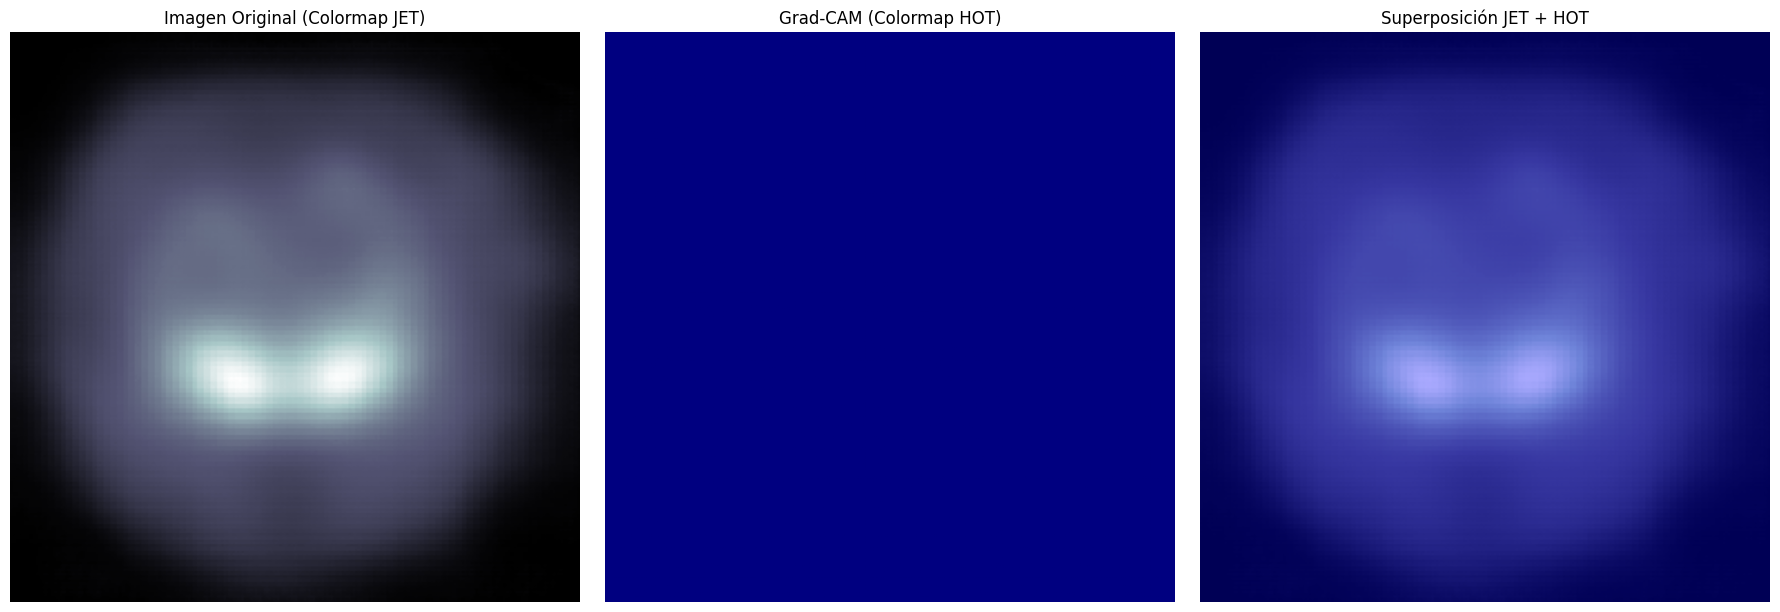

In [24]:
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
import cv2
#df = pd.read_csv('/home/Data/franklin_pupils/yeferson/Tesis/Datos_mri_spect_clinical.csv')
df = pd.read_csv("/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/spect_sinteticos.csv")
img = df['path_spect'].sample(1).values[0]
print(img)
img = Image.open(img)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
img = transform(img).to(device)
cam, img_np = vit_gradcam(model, img)
show_gradcam(cam, img_np)


# Clinical information - Antiguo

In [1]:
import pandas as pd
import numpy as np

df = df = pd.read_csv('/home/Data/franklin_pupils/yeferson/Tesis/Datos_mri_spect_clinical.csv')
df_Control = pd.read_excel('/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/embcExtension.xlsx', sheet_name='control')
df_PD = pd.read_excel('/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/embcExtension.xlsx', sheet_name='PD')
df2 = pd.read_csv('/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/MDS-UPDRS_Part_III_09Apr2025.csv')

print(df_Control.columns)
print(df_PD.columns)
print(df2.columns)

pacientes_control = df[df["clase_spect"] == 0]["paciente_spect"].unique()
pacientes_PD = df[df["clase_spect"] == 1]["paciente_spect"].unique()

print(len(pacientes_control))
print(len(pacientes_PD))

print(len(df_Control["Pat_id"].unique()))
print(len(df_PD["Pat_id"].unique()))

df_Control = df_Control[df_Control["Pat_id"].isin(pacientes_control)]
df_PD = df_PD[df_PD["Pat_id"].isin(pacientes_PD)]

print(len(df_Control["Pat_id"].unique()))
print(len(df_PD["Pat_id"].unique()))

for paciente in pacientes_control:
    # Filtrar registros del paciente en ambos DataFrames
    control_row = df_Control[df_Control["Pat_id"] == paciente]
    paciente_df2 = df2[df2["PATNO"] == paciente]
    
    if control_row.empty or paciente_df2.empty:
        continue  # Saltar si no hay datos para este paciente
    
    # Por defecto usaremos el último registro (como antes)
    row_to_use = paciente_df2.iloc[-1]
    
    # Intentar encontrar la fecha más cercana
    try:
        if 'date NeuroImg' in control_row.columns and not pd.isna(control_row['date NeuroImg'].iloc[0]):
            # Convertir la fecha de neuroimagen a datetime
            neuro_date = pd.to_datetime(control_row['date NeuroImg'].iloc[0])
            
            # Convertir fechas en df2 a datetime y calcular diferencias
            temp_df = paciente_df2.copy()
            temp_df['ORIG_ENTRY_DT'] = pd.to_datetime(temp_df["ORIG_ENTRY"], format='%Y-%m-%d', errors='coerce')
            temp_df['date_diff'] = abs(temp_df['ORIG_ENTRY_DT'] - neuro_date)
            
            # Ordenar por diferencia de fechas y tomar el primer registro (más cercano)
            temp_df = temp_df.sort_values('date_diff')
            row_to_use = temp_df.iloc[0]  # Registro con fecha más cercana
    except Exception as e:
        # Si hay error, seguimos usando el último registro
        print(f"Error al procesar fechas para paciente {paciente}: {str(e)}")
    
    # Ahora actualizamos las columnas usando el registro seleccionado
    for columna in df_Control.columns:
        if columna not in ["Pat_id", "Part 1", "Part 1P", "Part 2", "Part 4", "Genero", "Edad", "NP1COG", "Comentarios"]:
            if pd.isna(control_row[columna].iloc[0]):
                if columna == "H & Y Stage" and "NHY" in row_to_use:
                    df_Control.loc[df_Control["Pat_id"] == paciente, columna] = row_to_use["NHY"]
                elif columna == "date NeuroImg" and "ORIG_ENTRY" in row_to_use:
                    df_Control.loc[df_Control["Pat_id"] == paciente, columna] = row_to_use["ORIG_ENTRY"]
                elif columna in row_to_use:
                    df_Control.loc[df_Control["Pat_id"] == paciente, columna] = row_to_use[columna]
df_Control.to_csv("/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/embcExtension_control.csv", index=False)
        

Index(['Pat_id', 'Part 1', 'Part 1P', 'Part 2', 'NP3TOT', 'Part 4',
       'H & Y Stage', 'date NeuroImg', 'Genero', 'Edad', 'PDSTATE', 'DBSYN',
       'NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 'NP3RIGRL',
       'NP3RIGLL', 'NP3HMOVR', 'NP3HMOVL', 'NP3GAIT', 'NP3FRZGT', 'NP3PSTBL',
       'NP3POSTR', 'NP1COG', 'Comentarios'],
      dtype='object')
Index(['Pat_id', 'Part 1', 'Part 1P', 'Part 2', 'NP3TOT', 'Part 4',
       'H & Y Stage', 'date NeuroImg', 'Genero', 'Edad', 'PDSTATE', 'DBSYN',
       'NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 'NP3RIGRL',
       'NP3RIGLL', 'NP3HMOVR', 'NP3HMOVL', 'NP3GAIT', 'NP3FRZGT', 'NP3PSTBL',
       'NP3POSTR', 'NP1COG'],
      dtype='object')
Index(['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT', 'PDTRTMNT',
       'PDSTATE', 'HRPOSTMED', 'HRDBSON', 'HRDBSOFF', 'PDMEDYN', 'DBSYN',
       'ONOFFORDER', 'OFFEXAM', 'OFFNORSN', 'DBSOFFTM', 'ONEXAM', 'ONNORSN',
       'HIFUYN', 'DBSONTM', 'PDMEDDT', 'PDMEDTM', 'EXAMDT'

In [33]:
import pandas as pd
import numpy as np
df_Control = pd.read_excel('/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/embcExtension.xlsx', sheet_name='control')

print(not pd.isna(df_Control[df_Control["Pat_id"] == 100004]["Part 1"].values[-1]))

False


In [5]:
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
df_Control = pd.read_excel('/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/embcExtension.xlsx', sheet_name='control')
print(df_Control.columns)

Index(['Pat_id', 'Part 1', 'Part 1P', 'Part 2', 'NP3TOT', 'Part 4',
       'H & Y Stage', 'date NeuroImg', 'Genero', 'Edad', 'PDSTATE', 'DBSYN',
       'NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 'NP3RIGRL',
       'NP3RIGLL', 'NP3HMOVR', 'NP3HMOVL', 'NP3GAIT', 'NP3FRZGT', 'NP3PSTBL',
       'NP3POSTR', 'NP1COG', 'Comentarios'],
      dtype='object')


# Clinical information - Nuevo

In [7]:
import pandas as pd
import numpy as np

df = df = pd.read_csv('/home/Data/franklin_pupils/yeferson/Tesis/Datos_mri_spect_clinical.csv')
df_Control = pd.read_excel('/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/embcExtension.xlsx', sheet_name='control')
df_PD = pd.read_excel('/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/embcExtension.xlsx', sheet_name='PD')
df2 = pd.read_excel('/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/MDS-UPDRS_Part_III_11May2024.xlsx')

print(df_Control.columns)
print(df_PD.columns)
print(df2.columns)

pacientes_control = df[df["clase_spect"] == 0]["paciente_spect"].unique()
pacientes_PD = df[df["clase_spect"] == 1]["paciente_spect"].unique()

print(len(pacientes_control))
print(len(pacientes_PD))

print(len(df_Control["Pat_id"].unique()))
print(len(df_PD["Pat_id"].unique()))

df_Control = df_Control[df_Control["Pat_id"].isin(pacientes_control)]
df_PD = df_PD[df_PD["Pat_id"].isin(pacientes_PD)]

print(len(df_Control["Pat_id"].unique()))
print(len(df_PD["Pat_id"].unique()))

columnas_nuevas = ["NP3FTAPL", "NP3FTAPR", "NP3PRSPR"]
for columnas in columnas_nuevas:
    df_Control[columnas] = pd.NA
    df_PD[columnas] = pd.NA

for paciente in pacientes_control:
    # Filtrar registros del paciente en ambos DataFrames
    control_row = df_Control[df_Control["Pat_id"] == paciente]
    paciente_df2 = df2[df2["PATNO"] == paciente]
    
    if control_row.empty or paciente_df2.empty:
        continue  # Saltar si no hay datos para este paciente
    
    # Por defecto usaremos el último registro (como antes)
    row_to_use = paciente_df2.iloc[-1]
    
    # Intentar encontrar la fecha más cercana
    try:
        if 'date NeuroImg' in control_row.columns and not pd.isna(control_row['date NeuroImg'].iloc[0]):
            # Convertir la fecha de neuroimagen a datetime
            neuro_date = pd.to_datetime(control_row['date NeuroImg'].iloc[0])
            
            # Convertir fechas en df2 a datetime y calcular diferencias
            temp_df = paciente_df2.copy()
            temp_df['ORIG_ENTRY_DT'] = pd.to_datetime(temp_df["ORIG_ENTRY"], format='%Y-%m-%d', errors='coerce')
            temp_df['date_diff'] = abs(temp_df['ORIG_ENTRY_DT'] - neuro_date)
            
            # Ordenar por diferencia de fechas y tomar el primer registro (más cercano)
            temp_df = temp_df.sort_values('date_diff')
            row_to_use = temp_df.iloc[0]  # Registro con fecha más cercana
    except Exception as e:
        # Si hay error, seguimos usando el último registro
        print(f"Error al procesar fechas para paciente {paciente}: {str(e)}")
    
    # Ahora actualizamos las columnas usando el registro seleccionado
    for columna in df_Control.columns:
        if columna not in ["Pat_id", "Part 1", "Part 1P", "Part 2", "Part 4", "Genero", "Edad", "NP1COG", "Comentarios"]:
            if pd.isna(control_row[columna].iloc[0]):
                if columna == "H & Y Stage" and "NHY" in row_to_use:
                    df_Control.loc[df_Control["Pat_id"] == paciente, columna] = row_to_use["NHY"]
                elif columna == "date NeuroImg" and "ORIG_ENTRY" in row_to_use:
                    df_Control.loc[df_Control["Pat_id"] == paciente, columna] = row_to_use["ORIG_ENTRY"]
                elif columna in row_to_use:
                    df_Control.loc[df_Control["Pat_id"] == paciente, columna] = row_to_use[columna]
df_Control.to_csv("/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/embcExtension_control2.csv", index=False)

for paciente in pacientes_PD:

    pd_row = df_PD[df_PD["Pat_id"] == paciente]
    paciente_df2 = df2[df2["PATNO"] == paciente]

    if pd_row.empty or paciente_df2.empty:
        continue  # Saltar si no hay datos para este paciente

    # Por defecto usaremos el último registro (como antes)
    row_to_use = paciente_df2.iloc[-1]

    # Intentar encontrar la fecha más cercana
    try:
        if 'date NeuroImg' in pd_row.columns and not pd.isna(pd_row['date NeuroImg'].iloc[0]):
            # Convertir la fecha de neuroimagen a datetime
            neuro_date = pd.to_datetime(pd_row['date NeuroImg'].iloc[0])

            # Convertir fechas en df2 a datetime y calcular diferencias
            temp_df = paciente_df2.copy()
            temp_df['ORIG_ENTRY_DT'] = pd.to_datetime(temp_df["ORIG_ENTRY"], format='%Y-%m-%d', errors='coerce')
            temp_df['date_diff'] = abs(temp_df['ORIG_ENTRY_DT'] - neuro_date)

            # Ordenar por diferencia de fechas y tomar el primer registro (más cercano)
            temp_df = temp_df.sort_values('date_diff')
            row_to_use = temp_df.iloc[0]  # Registro con fecha más cercana
    except Exception as e:
        # Si hay error, seguimos usando el último registro
        print(f"Error al procesar fechas para paciente {paciente}: {str(e)}")

    # Ahora actualizamos las columnas usando el registro seleccionado
    for columna in df_PD.columns:
        if columna not in ["Pat_id", "Part 1", "Part 1P", "Part 2", "Part 4", "Genero", "Edad", "NP1COG", "Comentarios"]:
            if pd.isna(pd_row[columna].iloc[0]):
                if columna == "H & Y Stage" and "NHY" in row_to_use:
                    df_PD.loc[df_PD["Pat_id"] == paciente, columna] = row_to_use["NHY"]
                elif columna == "date NeuroImg" and "ORIG_ENTRY" in row_to_use:
                    df_PD.loc[df_PD["Pat_id"] == paciente, columna] = row_to_use["ORIG_ENTRY"]
                elif columna in row_to_use:
                    df_PD.loc[df_PD["Pat_id"] == paciente, columna] = row_to_use[columna]
df_PD.to_csv("/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/embcExtension_PD2.csv", index=False)


Index(['Pat_id', 'Part 1', 'Part 1P', 'Part 2', 'NP3TOT', 'Part 4',
       'H & Y Stage', 'date NeuroImg', 'Genero', 'Edad', 'PDSTATE', 'DBSYN',
       'NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 'NP3RIGRL',
       'NP3RIGLL', 'NP3HMOVR', 'NP3HMOVL', 'NP3GAIT', 'NP3FRZGT', 'NP3PSTBL',
       'NP3POSTR', 'NP1COG', 'Comentarios'],
      dtype='object')
Index(['Pat_id', 'Part 1', 'Part 1P', 'Part 2', 'NP3TOT', 'Part 4',
       'H & Y Stage', 'date NeuroImg', 'Genero', 'Edad', 'PDSTATE', 'DBSYN',
       'NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 'NP3RIGRL',
       'NP3RIGLL', 'NP3HMOVR', 'NP3HMOVL', 'NP3GAIT', 'NP3FRZGT', 'NP3PSTBL',
       'NP3POSTR', 'NP1COG'],
      dtype='object')
Index(['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT', 'PDTRTMNT',
       'PDSTATE', 'HRPOSTMED', 'HRDBSON', 'HRDBSOFF', 'PDMEDYN', 'DBSYN',
       'ONOFFORDER', 'OFFEXAM', 'OFFNORSN', 'DBSOFFTM', 'ONEXAM', 'ONNORSN',
       'DBSONTM', 'PDMEDDT', 'PDMEDTM', 'EXAMDT', 'EXAMTM'

In [9]:
import pandas as pd
df = pd.read_csv("/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/embcExtension_control2.csv")
df.head()


,Pat_id,Part 1,Part 1P,Part 2,NP3TOT,Part 4,H & Y Stage,date NeuroImg,Genero,Edad,...,NP3HMOVL,NP3GAIT,NP3FRZGT,NP3PSTBL,NP3POSTR,NP1COG,Comentarios,NP3FTAPL,NP3FTAPR,NP3PRSPR
0,3104,NaN,NaN,NaN,2.0,NaN,0.0,04/20/2012,M,73.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
1,3112,NaN,NaN,NaN,0.0,NaN,0.0,08/30/2011,F,63.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2,3157,NaN,NaN,NaN,3.0,NaN,0.0,2012-01-03 00:00:00,F,65.0,...,0.0,0.0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0
3,3160,NaN,NaN,NaN,0.0,NaN,0.0,03/21/2012,M,81.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
4,3320,NaN,NaN,NaN,0.0,NaN,0.0,05/31/2012,M,56.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load the control data
df_control = pd.read_csv("/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/embcExtension_control.csv")

# Load the Parkinson's data
df_parkinson = pd.read_excel('/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/embcExtension.xlsx', sheet_name='PD')

# Define the list of columns to use for classification
columnas_a_usar = ['DBSYN', 'NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 
                   'NP3RIGRL', 'NP3RIGLL', 'NP3HMOVR', 'NP3HMOVL', 'NP3GAIT', 'NP3FRZGT', 'NP3PSTBL', 'NP3POSTR']

# Preprocessing df_control
df_control['target'] = 0

# Preprocessing df_parkinson
df_parkinson['target'] = 1


# Combine dataframes, selecting only the required columns
combined_df = pd.concat([
    df_control[columnas_a_usar + ['target']], 
    df_parkinson[columnas_a_usar + ['target']]
], ignore_index=True)


for col in columnas_a_usar:
    if combined_df[col].isnull().any():
        if pd.api.types.is_numeric_dtype(combined_df[col]):
            median_val = combined_df[col].median()
            combined_df[col] = combined_df[col].fillna(median_val)
        else:
            print(f"Warning: Column {col} is not numeric and has NaNs. Filling with 0. Review imputation strategy.")
            combined_df[col] = combined_df[col].fillna(0) 

# Ensure all feature columns are numeric
for col in columnas_a_usar:
    if not pd.api.types.is_numeric_dtype(combined_df[col]):
        print(f"Error: Column {col} is not numeric after preprocessing. Type: {combined_df[col].dtype}")
        combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')
        if combined_df[col].isnull().any(): 
             combined_df[col] = combined_df[col].fillna(combined_df[col].median()) 


# Prepare data for modeling
X = combined_df[columnas_a_usar]
y = combined_df['target']

# PyTorch specific part:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dims = X.shape[1]
epochs = 100 # Number of epochs for training each fold
batch_size = 16
lr = 0.001

# Define the PyTorch neural network model
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.layer_1 = nn.Linear(input_size, 64)
        self.relu_1 = nn.ReLU()
        self.dropout_1 = nn.Dropout(0.3)
        self.layer_2 = nn.Linear(64, 32)
        self.relu_2 = nn.ReLU()
        self.dropout_2 = nn.Dropout(0.3)
        self.output_layer = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.dropout_1(self.relu_1(self.layer_1(x)))
        x = self.dropout_2(self.relu_2(self.layer_2(x)))
        x = self.sigmoid(self.output_layer(x))
        return x

# Cross-validation setup
n_splits = 20 # Number of folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_test_losses = []
fold_accuracies = []
fold_aucs = []
fold_classification_reports = []


for fold, (train_idx, test_idx) in enumerate(tqdm(skf.split(X, y), total=n_splits, desc="Cross-validation Folds")):
    # print(f"\n--- Fold {fold+1}/{n_splits} ---")
    
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

    # Scale numerical features for the current fold
    scaler = StandardScaler()
    X_train_scaled_fold = scaler.fit_transform(X_train_fold)
    X_test_scaled_fold = scaler.transform(X_test_fold)

    # Convert data to PyTorch Tensors for the current fold
    X_train_tensor = torch.FloatTensor(X_train_scaled_fold).to(device)
    y_train_tensor = torch.FloatTensor(y_train_fold.values.reshape(-1, 1)).to(device)
    X_test_tensor = torch.FloatTensor(X_test_scaled_fold).to(device)
    y_test_tensor = torch.FloatTensor(y_test_fold.values.reshape(-1, 1)).to(device)

    # Create DataLoader for training for the current fold
    train_dataset_fold = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader_fold = DataLoader(train_dataset_fold, batch_size=batch_size, shuffle=True)

    # Instantiate the model, define loss function and optimizer for the current fold
    model = Net(input_dims).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train the model for the current fold
    for epoch in range(epochs): # tqdm(range(epochs), desc=f"Fold {fold+1} Training", leave=False):
        model.train()
        for batch_X, batch_y in train_loader_fold:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
    
    # Evaluate the model for the current fold
    model.eval()
    with torch.no_grad():
        y_pred_proba_tensor = model(X_test_tensor)
        test_loss = criterion(y_pred_proba_tensor, y_test_tensor).item()
        y_pred_proba = y_pred_proba_tensor.cpu().numpy()
        y_pred_classes = (y_pred_proba > 0.5).astype(int)

    # Calculate metrics for the current fold
    accuracy = accuracy_score(y_test_fold.values, y_pred_classes)
    sklearn_auc = roc_auc_score(y_test_fold.values, y_pred_proba)
    report = classification_report(y_test_fold.values, y_pred_classes, target_names=['Control', 'Parkinson'], output_dict=True, zero_division=0)


    fold_test_losses.append(test_loss)
    fold_accuracies.append(accuracy)
    fold_aucs.append(sklearn_auc)
    fold_classification_reports.append(report)
    
    # print(f"Fold {fold+1} Test Loss: {test_loss:.4f}")
    # print(f"Fold {fold+1} Test Accuracy: {accuracy:.4f}")
    # print(f"Fold {fold+1} Test AUC: {sklearn_auc:.4f}")
    # print(f"Fold {fold+1} Classification Report:\n{classification_report(y_test_fold.values, y_pred_classes, target_names=['Control', 'Parkinson'], zero_division=0)}")


# Calculate and print average metrics across all folds
print(f"\n--- Cross-Validation Results ({n_splits} folds) ---")
print(f"Average Test Loss: {np.mean(fold_test_losses):.4f} +/- {np.std(fold_test_losses):.4f}")
print(f"Average Test Accuracy: {np.mean(fold_accuracies):.4f} +/- {np.std(fold_accuracies):.4f}")
print(f"Average precision: {np.mean([rep['Control']['precision'] for rep in fold_classification_reports]):.4f} +/- {np.std([rep['Control']['precision'] for rep in fold_classification_reports]):.4f}")
print(f"Average recall: {np.mean([rep['Control']['recall'] for rep in fold_classification_reports]):.4f} +/- {np.std([rep['Control']['recall'] for rep in fold_classification_reports]):.4f}")
print(f"Average F1-score: {np.mean([rep['Control']['f1-score'] for rep in fold_classification_reports]):.4f} +/- {np.std([rep['Control']['f1-score'] for rep in fold_classification_reports]):.4f}")
print(f"Average Test AUC: {np.mean(fold_aucs):.4f} +/- {np.std(fold_aucs):.4f}")

# Averaging classification report metrics (example for 'Parkinson' class precision)
avg_precision_parkinson = np.mean([rep['Parkinson']['precision'] for rep in fold_classification_reports])
avg_recall_parkinson = np.mean([rep['Parkinson']['recall'] for rep in fold_classification_reports])
avg_f1_parkinson = np.mean([rep['Parkinson']['f1-score'] for rep in fold_classification_reports])

avg_precision_control = np.mean([rep['Control']['precision'] for rep in fold_classification_reports])
avg_recall_control = np.mean([rep['Control']['recall'] for rep in fold_classification_reports])
avg_f1_control = np.mean([rep['Control']['f1-score'] for rep in fold_classification_reports])

print("\nAverage Classification Metrics:")
print(f"  Control - Precision: {avg_precision_control:.4f}, Recall: {avg_recall_control:.4f}, F1-score: {avg_f1_control:.4f}")
print(f"  Parkinson - Precision: {avg_precision_parkinson:.4f}, Recall: {avg_recall_parkinson:.4f}, F1-score: {avg_f1_parkinson:.4f}")

Cross-validation Folds: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s]


--- Cross-Validation Results (20 folds) ---
Average Test Loss: 0.1972 +/- 0.3517
Average Test Accuracy: 0.9500 +/- 0.0780
Average precision: 0.9008 +/- 0.1470
Average recall: 0.9208 +/- 0.1835
Average F1-score: 0.9050 +/- 0.1618
Average Test AUC: 0.9842 +/- 0.0263

Average Classification Metrics:
  Control - Precision: 0.9008, Recall: 0.9208, F1-score: 0.9050
  Parkinson - Precision: 0.9708, Recall: 0.9628, F1-score: 0.9657


# Motor information

In [1]:
import pandas as pd

df_control = pd.read_csv("/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/embcExtension_control.csv")
print(df_control.columns)

Index(['Pat_id', 'Part 1', 'Part 1P', 'Part 2', 'NP3TOT', 'Part 4',
       'H & Y Stage', 'date NeuroImg', 'Genero', 'Edad', 'PDSTATE', 'DBSYN',
       'NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 'NP3RIGRL',
       'NP3RIGLL', 'NP3HMOVR', 'NP3HMOVL', 'NP3GAIT', 'NP3FRZGT', 'NP3PSTBL',
       'NP3POSTR', 'NP1COG', 'Comentarios'],
      dtype='object')


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load the control data
df_control = pd.read_csv("/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/embcExtension_control.csv")

# Load the Parkinson's data
df_parkinson = pd.read_excel('/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/embcExtension.xlsx', sheet_name='PD')

# Define the list of columns to use for classification
columnas_a_usar = ['NP3RIGRU', 'NP3RIGLU', 
                   'NP3RIGRL', 'NP3RIGLL', 'NP3HMOVR', 'NP3HMOVL']

# Preprocessing df_control
df_control['target'] = 0

# Preprocessing df_parkinson
df_parkinson['target'] = 1


# Combine dataframes, selecting only the required columns
combined_df = pd.concat([
    df_control[columnas_a_usar + ['target']], 
    df_parkinson[columnas_a_usar + ['target']]
], ignore_index=True)


for col in columnas_a_usar:
    if combined_df[col].isnull().any():
        if pd.api.types.is_numeric_dtype(combined_df[col]):
            median_val = combined_df[col].median()
            combined_df[col] = combined_df[col].fillna(median_val)
        else:
            print(f"Warning: Column {col} is not numeric and has NaNs. Filling with 0. Review imputation strategy.")
            combined_df[col] = combined_df[col].fillna(0) 

# Ensure all feature columns are numeric
for col in columnas_a_usar:
    if not pd.api.types.is_numeric_dtype(combined_df[col]):
        print(f"Error: Column {col} is not numeric after preprocessing. Type: {combined_df[col].dtype}")
        combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')
        if combined_df[col].isnull().any(): 
             combined_df[col] = combined_df[col].fillna(combined_df[col].median()) 


# Prepare data for modeling
X = combined_df[columnas_a_usar]
y = combined_df['target']

# PyTorch specific part:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dims = X.shape[1]
epochs = 100 # Number of epochs for training each fold
batch_size = 16
lr = 0.001

# Define the PyTorch neural network model
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.layer_1 = nn.Linear(input_size, 64)
        self.relu_1 = nn.ReLU()
        self.dropout_1 = nn.Dropout(0.3)
        self.layer_2 = nn.Linear(64, 32)
        self.relu_2 = nn.ReLU()
        self.dropout_2 = nn.Dropout(0.3)
        self.output_layer = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.dropout_1(self.relu_1(self.layer_1(x)))
        x = self.dropout_2(self.relu_2(self.layer_2(x)))
        x = self.sigmoid(self.output_layer(x))
        return x

# Cross-validation setup
n_splits = 20 # Number of folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_test_losses = []
fold_accuracies = []
fold_aucs = []
fold_classification_reports = []


for fold, (train_idx, test_idx) in enumerate(tqdm(skf.split(X, y), total=n_splits, desc="Cross-validation Folds")):
    # print(f"\n--- Fold {fold+1}/{n_splits} ---")
    
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

    # Scale numerical features for the current fold
    scaler = StandardScaler()
    X_train_scaled_fold = scaler.fit_transform(X_train_fold)
    X_test_scaled_fold = scaler.transform(X_test_fold)

    # Convert data to PyTorch Tensors for the current fold
    X_train_tensor = torch.FloatTensor(X_train_scaled_fold).to(device)
    y_train_tensor = torch.FloatTensor(y_train_fold.values.reshape(-1, 1)).to(device)
    X_test_tensor = torch.FloatTensor(X_test_scaled_fold).to(device)
    y_test_tensor = torch.FloatTensor(y_test_fold.values.reshape(-1, 1)).to(device)

    # Create DataLoader for training for the current fold
    train_dataset_fold = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader_fold = DataLoader(train_dataset_fold, batch_size=batch_size, shuffle=True)

    # Instantiate the model, define loss function and optimizer for the current fold
    model = Net(input_dims).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train the model for the current fold
    for epoch in range(epochs): # tqdm(range(epochs), desc=f"Fold {fold+1} Training", leave=False):
        model.train()
        for batch_X, batch_y in train_loader_fold:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
    
    # Evaluate the model for the current fold
    model.eval()
    with torch.no_grad():
        y_pred_proba_tensor = model(X_test_tensor)
        test_loss = criterion(y_pred_proba_tensor, y_test_tensor).item()
        y_pred_proba = y_pred_proba_tensor.cpu().numpy()
        y_pred_classes = (y_pred_proba > 0.5).astype(int)

    # Calculate metrics for the current fold
    accuracy = accuracy_score(y_test_fold.values, y_pred_classes)
    sklearn_auc = roc_auc_score(y_test_fold.values, y_pred_proba)
    report = classification_report(y_test_fold.values, y_pred_classes, target_names=['Control', 'Parkinson'], output_dict=True, zero_division=0)


    fold_test_losses.append(test_loss)
    fold_accuracies.append(accuracy)
    fold_aucs.append(sklearn_auc)
    fold_classification_reports.append(report)
    
    # print(f"Fold {fold+1} Test Loss: {test_loss:.4f}")
    # print(f"Fold {fold+1} Test Accuracy: {accuracy:.4f}")
    # print(f"Fold {fold+1} Test AUC: {sklearn_auc:.4f}")
    # print(f"Fold {fold+1} Classification Report:\n{classification_report(y_test_fold.values, y_pred_classes, target_names=['Control', 'Parkinson'], zero_division=0)}")


# Calculate and print average metrics across all folds
print(f"\n--- Cross-Validation Results ({n_splits} folds) ---")
print(f"Average Test Loss: {np.mean(fold_test_losses):.4f} +/- {np.std(fold_test_losses):.4f}")
print(f"Average Test Accuracy: {np.mean(fold_accuracies):.4f} +/- {np.std(fold_accuracies):.4f}")
print(f"Average precision: {np.mean([rep['Control']['precision'] for rep in fold_classification_reports]):.4f} +/- {np.std([rep['Control']['precision'] for rep in fold_classification_reports]):.4f}")
print(f"Average recall: {np.mean([rep['Control']['recall'] for rep in fold_classification_reports]):.4f} +/- {np.std([rep['Control']['recall'] for rep in fold_classification_reports]):.4f}")
print(f"Average F1-score: {np.mean([rep['Control']['f1-score'] for rep in fold_classification_reports]):.4f} +/- {np.std([rep['Control']['f1-score'] for rep in fold_classification_reports]):.4f}")
print(f"Average Test AUC: {np.mean(fold_aucs):.4f} +/- {np.std(fold_aucs):.4f}")

# Averaging classification report metrics (example for 'Parkinson' class precision)
avg_precision_parkinson = np.mean([rep['Parkinson']['precision'] for rep in fold_classification_reports])
avg_recall_parkinson = np.mean([rep['Parkinson']['recall'] for rep in fold_classification_reports])
avg_f1_parkinson = np.mean([rep['Parkinson']['f1-score'] for rep in fold_classification_reports])

avg_precision_control = np.mean([rep['Control']['precision'] for rep in fold_classification_reports])
avg_recall_control = np.mean([rep['Control']['recall'] for rep in fold_classification_reports])
avg_f1_control = np.mean([rep['Control']['f1-score'] for rep in fold_classification_reports])

print("\nAverage Classification Metrics:")
print(f"  Control - Precision: {avg_precision_control:.4f}, Recall: {avg_recall_control:.4f}, F1-score: {avg_f1_control:.4f}")
print(f"  Parkinson - Precision: {avg_precision_parkinson:.4f}, Recall: {avg_recall_parkinson:.4f}, F1-score: {avg_f1_parkinson:.4f}")

Cross-validation Folds: 100%|██████████| 20/20 [00:33<00:00,  1.69s/it]


--- Cross-Validation Results (20 folds) ---
Average Test Loss: 0.5949 +/- 0.0319
Average Test Accuracy: 0.7183 +/- 0.0356
Average precision: 0.0000 +/- 0.0000
Average recall: 0.0000 +/- 0.0000
Average F1-score: 0.0000 +/- 0.0000
Average Test AUC: 0.5000 +/- 0.0000

Average Classification Metrics:
  Control - Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000
  Parkinson - Precision: 0.7183, Recall: 1.0000, F1-score: 0.8355


# Combinar imagenes

In [ ]:
import numpy as np
data_csv_path1 = '/home/Data/franklin_pupils/yeferson/Tesis/Datos_mri_spect_clinical.csv'
data_csv_path2 = '/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/spect_sinteticos.csv'

df1 = pd.read_csv(data_csv_path1)
df2 = pd.read_csv(data_csv_path2)

pacientes_unicos1 = set(df1['paciente_mri'].unique())
pacientes_unicos2 = set(df2['paciente_spect'].unique())

print(f"Pacientes únicos en MRI: {len(pacientes_unicos1)}")
print(f"Pacientes únicos en SPECT: {len(pacientes_unicos2)}")   

pacientes_no_comunes = pacientes_unicos2.difference(pacientes_unicos1)
pacientes_unicos2 = pacientes_unicos2 - pacientes_no_comunes
print(f"Pacientes únicos en SPECT que no están en MRI: {len(pacientes_unicos2)}")

df2 = df2[df2['paciente_spect'].isin(pacientes_unicos2)]
data_csv_path2 = '/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/spect_sinteticos_filtrados.csv'
df2.to_csv(data_csv_path2, index=False)

In [ ]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

data_csv_path1 = '/home/Data/franklin_pupils/yeferson/Tesis/Datos_mri_spect_clinical.csv'
data_csv_path2 = '/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/spect_sinteticos_filtrados.csv'

df1 = pd.read_csv(data_csv_path1)
df2 = pd.read_csv(data_csv_path2)


img1 = Image.open(df1['path_mri'].iloc[0]).convert("RGBA")
img2 = Image.open(df2['path_spect'].iloc[0]).convert("RGBA")
img2 = img2.resize(img1.size)  # Redimensiona img2 al tamaño de img1 si es necesario

# Mezclar las dos imágenes (alpha=0.7 para 70% de img2 y 30% de img1)
superpuesta = Image.blend(img1, img2, alpha=0.7)
superpuesta = superpuesta.convert("L")  # Convertir a escala de grises (modo "L" en PIL)

# Mostrar la imagen superpuesta usando matplotlib (que sí acepta cmap)
plt.figure(figsize=(8, 8))
plt.imshow(superpuesta, cmap="jet")
plt.axis('off')
plt.title('Imagen superpuesta MRI + SPECT')
plt.show()


In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image


class CustomDataLoader(Dataset):
    def __init__(self, csv_mri, csv_spect, img_res=(256, 256), mode='train', alpha=0.5):
        self.df_mri = pd.read_csv(csv_mri)
        self.df_spect = pd.read_csv(csv_spect)
        self.img_res = img_res
        self.mode = mode
        self.alpha = alpha

        # Filtrar por modo
        self.mri_df = self.df_mri[self.df_mri['tipo_mri'] == mode]
        self.spect_df = self.df_spect[self.df_spect['tipo_spect'] == mode]

        # Crear lista de muestras: [(mri_row, spect_row)]
        self.samples = []
        for _, mri_row in self.mri_df.iterrows():
            paciente = mri_row['paciente_mri']
            spect_rows = self.spect_df[self.spect_df['paciente_spect'] == paciente]
            if not spect_rows.empty:
                spect_row = spect_rows.iloc[0]  # Puedes cambiar la lógica si quieres otro emparejamiento
                self.samples.append((mri_row, spect_row))
            # Si no hay SPECT para ese paciente, se omite

        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize(self.img_res),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        mri_row, spect_row = self.samples[idx]
        label = int(mri_row['clase_mri'])
        mri_img = Image.open(mri_row['path_mri']).convert("RGBA")
        spect_img = Image.open(spect_row['path_spect']).convert("RGBA")
        spect_img = spect_img.resize(mri_img.size)
        combined_img = Image.blend(mri_img, spect_img, alpha=self.alpha)
        combined_img = combined_img.convert("L")
        combined_tensor = self.transform(combined_img)
        return combined_tensor, label

# Ruta del archivo CSV
csv_mri = '/home/Data/franklin_pupils/yeferson/Tesis/Datos_mri_spect_clinical.csv'
csv_spect_sinteicos = '/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/spect_sinteticos.csv'

In [2]:
import torch
import torch.nn as nn
import math

class CNNStem(nn.Module):
    def __init__(self, in_chans=1, out_chans=128):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(in_chans, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, out_chans, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_chans),
            nn.ReLU()
        )

    def forward(self, x):
        return self.stem(x)

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=64, patch_size=4, in_chans=128, embed_dim=768):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch, W/patch)
        x = x.flatten(2).transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, dropout=0.0):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=True)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropout)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
        q, k, v = qkv.permute(2, 0, 3, 1, 4)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return self.proj_drop(x)

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, dropout=0.0):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        x = self.drop(self.act(self.fc1(x)))
        x = self.drop(self.fc2(x))
        return x

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, int(dim * mlp_ratio), dropout=dropout)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size=256, patch_size=4, in_chans=1, num_classes=2,
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        # Etapa convolucional inicial
        self.cnn_stem = CNNStem(in_chans=in_chans, out_chans=128)

        # Patch embedding sobre el output convolucional
        reduced_img_size = img_size // 4  # CNNStem reduce por factor 4
        self.patch_embed = PatchEmbedding(
            img_size=reduced_img_size, patch_size=patch_size,
            in_chans=128, embed_dim=embed_dim
        )
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + num_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=dropout)

        self.blocks = nn.Sequential(*[
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, x):
        B = x.shape[0]
        x = self.cnn_stem(x)                       # (B, 128, 64, 64)
        x = self.patch_embed(x)                    # (B, num_patches, embed_dim)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)      # (B, num_patches+1, embed_dim)
        x = self.pos_drop(x + self.pos_embed)      # Añadir embedding posicional
        x = self.blocks(x)                         # Pasar por bloques transformer
        x = self.norm(x[:, 0])                     # Tomar el token de clase
        return self.head(x)                        # Clasificación


Epoch 10/10: 100%|██████████| 1421/1421 [03:05<00:00,  7.67it/s, accuracy=49.8, loss=0.0434]
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

              precision    recall  f1-score   support

     Clase 0       0.00      0.00      0.00      2940
     Clase 1       0.48      1.00      0.65      2744

    accuracy                           0.48      5684
   macro avg       0.24      0.50      0.33      5684
weighted avg       0.23      0.48      0.31      5684

AUC: 0.5000


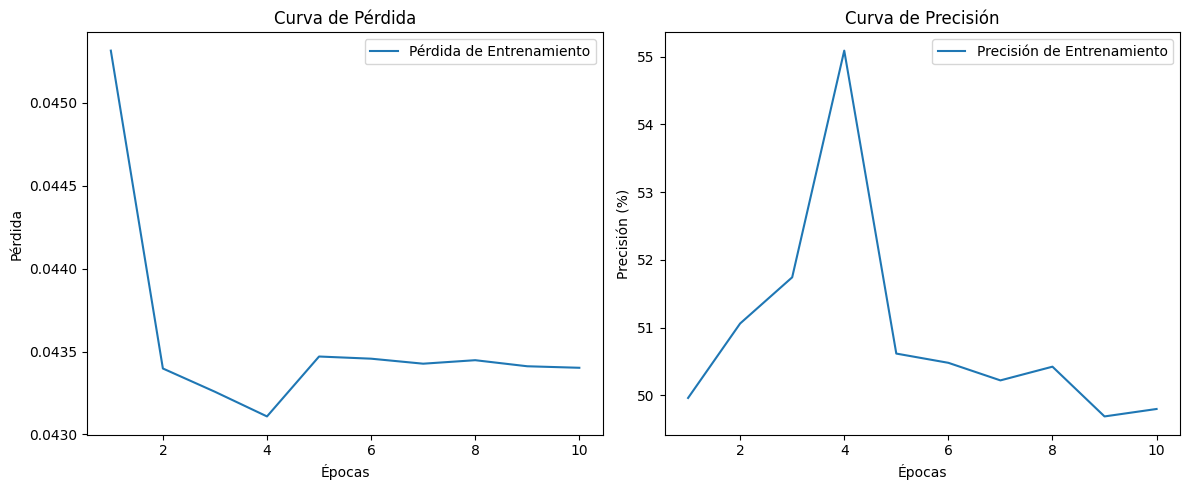

In [3]:
from tqdm import tqdm
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import pandas as pd
from sklearn.metrics import roc_auc_score

# Crear datasets y dataloaders usando CustomDataLoader
train_dataset = CustomDataLoader(csv_mri, csv_spect_sinteicos, img_res=(256, 256), mode='train')
test_dataset = CustomDataLoader(csv_mri, csv_spect_sinteicos, img_res=(256, 256), mode='test')

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Inicializar el modelo, la función de pérdida y el optimizador
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer(img_size=256, patch_size=16, in_chans=1, num_classes=2, embed_dim=768, depth=12, num_heads=12).to(device)
#nombre = "spect_sinteticos_2_head"
#model.load_state_dict(torch.load(f"/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/{nombre}.pth"))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento del modelo
epochs = 10
# Listas para almacenar las métricas de entrenamiento
train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []
epochs = 10
# Entrenamiento del modelo
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}") as t:
        for images, labels in t:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            t.set_postfix(loss=train_loss / total, accuracy=100. * correct / total)

    # Guardar métricas de la época
    train_losses.append(train_loss / total)
    train_accuracies.append(100. * correct / total)

# Evaluación del modelo en el conjunto de prueba
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Generar el reporte de clasificación
report = classification_report(all_labels, all_predictions, target_names=["Clase 0", "Clase 1"])
print(report)
#Calcular el AUC

auc = roc_auc_score(all_labels, all_predictions)
print(f"AUC: {auc:.4f}")

# Visualización de las métricas de entrenamiento
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

#Gráfico de pérdida
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Pérdida de Entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.title("Curva de Pérdida")
plt.legend()

# Gráfico de precisión
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Precisión de Entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Precisión (%)")
plt.title("Curva de Precisión")
plt.legend()

plt.tight_layout()
plt.show()

In [4]:
nombre = "mri_spect_sinteticos_12_head"
torch.save(model.state_dict(), f"/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/{nombre}.pth")

# MRI + Clinical

In [ ]:

# Load the control data
df_control = pd.read_csv("/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/embcExtension_control.csv")

# Load the Parkinson's data
df_parkinson = pd.read_excel('/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/embcExtension.xlsx', sheet_name='PD')

# Define the list of columns to use for classification
columnas_a_usar = ['DBSYN', 'NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 
                   'NP3RIGRL', 'NP3RIGLL', 'NP3HMOVR', 'NP3HMOVL', 'NP3GAIT', 'NP3FRZGT', 'NP3PSTBL', 'NP3POSTR']


In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np

class ClinicalImageDataset(Dataset):
    def __init__(self, img_csv_path, clinical_control_csv, clinical_pd_excel, img_res=(256, 256), 
                 mode='train', img_col='mri', clinical_features=None):
        self.img_df = pd.read_csv(img_csv_path)
        self.control_df = pd.read_csv(clinical_control_csv)
        self.pd_df = pd.read_excel(clinical_pd_excel, sheet_name='PD')
        self.img_res = img_res
        self.mode = mode
        self.img_col = img_col
        
        # Define clinical features to use if not provided
        self.clinical_features = clinical_features if clinical_features is not None else [
            'DBSYN', 'NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 
            'NP3RIGRL', 'NP3RIGLL', 'NP3HMOVR', 'NP3HMOVL', 'NP3GAIT', 'NP3FRZGT', 
            'NP3PSTBL', 'NP3POSTR'
        ]
        
        # Filter images by mode
        self.img_train_df = self.img_df[self.img_df[f'tipo_{self.img_col}'] == 'train']
        self.img_test_df = self.img_df[self.img_df[f'tipo_{self.img_col}'] == 'test']
        
        # Create samples list with available clinical data
        self.samples = []
        
        # Select appropriate dataset based on mode
        img_dataset = self.img_train_df if mode == 'train' else self.img_test_df
        
        # For each image, try to find its clinical data
        for idx, row in img_dataset.iterrows():
            patient_id = int(row[f'paciente_{self.img_col}'])
            label = int(row[f'clase_{self.img_col}'])
            
            # Find clinical data based on label (0=control, 1=PD)
            clinical_data = None
            if label == 0:
                # Search in control dataframe
                control_patient = self.control_df[self.control_df['Pat_id'] == int(patient_id)]
                if not control_patient.empty:
                    clinical_data = control_patient[self.clinical_features].iloc[0]
            else:
                # Search in PD dataframe
                pd_patient = self.pd_df[self.pd_df['Pat_id'] == patient_id]
                if not pd_patient.empty:
                    clinical_data = pd_patient[self.clinical_features].iloc[0]

                    
            
            # If clinical data is available, add to samples
            if clinical_data is not None:
                self.samples.append((row, clinical_data, label))
        
        # Print dataset summary
        print(f"Mode: {mode}, Total samples with clinical data: {len(self.samples)}")
        
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize(self.img_res),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_row, clinical_data, label = self.samples[idx]
        
        # Process image
        img_path = img_row[f'path_{self.img_col}']
        img = Image.open(img_path)
        img_tensor = self.transform(img)
        
        # Process clinical features
        clinical_values = []
        for feature in self.clinical_features:
            if feature in clinical_data:
                # Try to convert to float, use 0.0 if conversion fails
                try:
                    value = float(clinical_data[feature])
                    clinical_values.append(value)
                except (ValueError, TypeError):
                    clinical_values.append(0.0)
            else:
                clinical_values.append(0.0)  # Default value if feature not found
        
        clinical_tensor = torch.tensor(clinical_values, dtype=torch.float)
        
        return img_tensor, clinical_tensor, label

# Example usage
img_csv_path = '/home/Data/franklin_pupils/yeferson/Tesis/Datos_mri_spect_clinical.csv'
clinical_control_csv = '/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/embcExtension_control.csv'
clinical_pd_excel = '/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/embcExtension.xlsx'

In [2]:
import torch
import torch.nn as nn
import math

class CNNStem(nn.Module):
    def __init__(self, in_chans=1, out_chans=128):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(in_chans, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, out_chans, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_chans),
            nn.ReLU()
        )

    def forward(self, x):
        return self.stem(x)

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=64, patch_size=4, in_chans=128, embed_dim=768):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch, W/patch)
        x = x.flatten(2).transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, dropout=0.0):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=True)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropout)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
        q, k, v = qkv.permute(2, 0, 3, 1, 4)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return self.proj_drop(x)

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, dropout=0.0):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        x = self.drop(self.act(self.fc1(x)))
        x = self.drop(self.fc2(x))
        return x

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, int(dim * mlp_ratio), dropout=dropout)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class ClinicalEncoder(nn.Module):
    def __init__(self, clinical_dim, num_categories=5, embed_dim_per_var=16, output_dim=768):
        super().__init__()
        self.clinical_dim = clinical_dim
        self.num_categories = num_categories
        
        # Opción 1: Embeddings para cada variable categórica (RECOMENDADO)
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_categories, embed_dim_per_var) 
            for _ in range(clinical_dim)
        ])
        
        # Red para procesar embeddings concatenados
        total_embed_dim = clinical_dim * embed_dim_per_var
        self.encoder = nn.Sequential(
            nn.Linear(total_embed_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, output_dim)
        )
    
    def forward(self, x):
        # x shape: (batch_size, clinical_dim)
        embedded_features = []
        for i in range(self.clinical_dim):
            # Convertir a enteros para embedding
            var_values = x[:, i].long()
            embedded = self.embeddings[i](var_values)
            embedded_features.append(embedded)
        
        # Concatenar todos los embeddings
        combined = torch.cat(embedded_features, dim=1)
        return self.encoder(combined)

# Alternativa: Encoder más simple si prefieres mantener valores continuos
class SimpleClinicalEncoder(nn.Module):
    def __init__(self, clinical_dim, output_dim=768):
        super().__init__()
        self.encoder = nn.Sequential(
            # Normalización inicial
            nn.BatchNorm1d(clinical_dim),
            nn.Linear(clinical_dim, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, output_dim),
            nn.Dropout(0.1)
        )
    
    def forward(self, x):
        # Normalizar valores a rango [0, 1]
        x_norm = x / 4.0  # Ya que el rango es 0-4
        return self.encoder(x_norm)

class VisionTransformer(nn.Module):
    def __init__(self, img_size=256, patch_size=16, in_chans=1, num_classes=2,
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.0, dropout=0.1,
                 clinical_dim=14, use_embeddings=True):
        super().__init__()
        # Componentes de imagen (sin cambios)
        self.cnn_stem = CNNStem(in_chans=in_chans, out_chans=128)
        
        reduced_img_size = img_size // 4
        self.patch_embed = PatchEmbedding(
            img_size=reduced_img_size, patch_size=patch_size,
            in_chans=128, embed_dim=embed_dim
        )
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + num_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=dropout)

        self.blocks = nn.Sequential(*[
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        
        # Encoder de variables clínicas mejorado
        if use_embeddings:
            self.clinical_encoder = ClinicalEncoder(
                clinical_dim=clinical_dim, 
                num_categories=5, 
                embed_dim_per_var=16, 
                output_dim=embed_dim
            )
        else:
            self.clinical_encoder = SimpleClinicalEncoder(
                clinical_dim=clinical_dim, 
                output_dim=embed_dim
            )
        
        # Fusión mejorada con attention
        self.fusion_attention = nn.MultiheadAttention(embed_dim, num_heads=8, dropout=0.1)
        self.fusion_norm = nn.LayerNorm(embed_dim)
        
        # Clasificador final
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 2),
            nn.LayerNorm(embed_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(embed_dim // 2, num_classes)
        )

        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, x, clinical_data):
        B = x.shape[0]
        
        # Procesar imagen
        x = self.cnn_stem(x)
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = self.pos_drop(x + self.pos_embed)
        x = self.blocks(x)
        img_features = self.norm(x[:, 0])  # (B, embed_dim)
        
        # Procesar datos clínicos
        clinical_features = self.clinical_encoder(clinical_data)  # (B, embed_dim)
        
        # Fusión con attention cruzada
        # Preparar para attention: (seq_len, batch, embed_dim)
        img_query = img_features.unsqueeze(0)  # (1, B, embed_dim)
        clinical_key_value = clinical_features.unsqueeze(0)  # (1, B, embed_dim)
        
        # Cross-attention: imagen atiende a características clínicas
        fused_features, _ = self.fusion_attention(
            img_query, clinical_key_value, clinical_key_value
        )
        fused_features = fused_features.squeeze(0)  # (B, embed_dim)
        
        # Conexión residual y normalización
        fused_features = self.fusion_norm(fused_features + img_features)
        
        return self.classifier(fused_features)

              precision    recall  f1-score   support

     Clase 0       1.00      0.93      0.97      2940
     Clase 1       0.93      1.00      0.97      2744

    accuracy                           0.97      5684
   macro avg       0.97      0.97      0.97      5684
weighted avg       0.97      0.97      0.97      5684

AUC: 0.9667


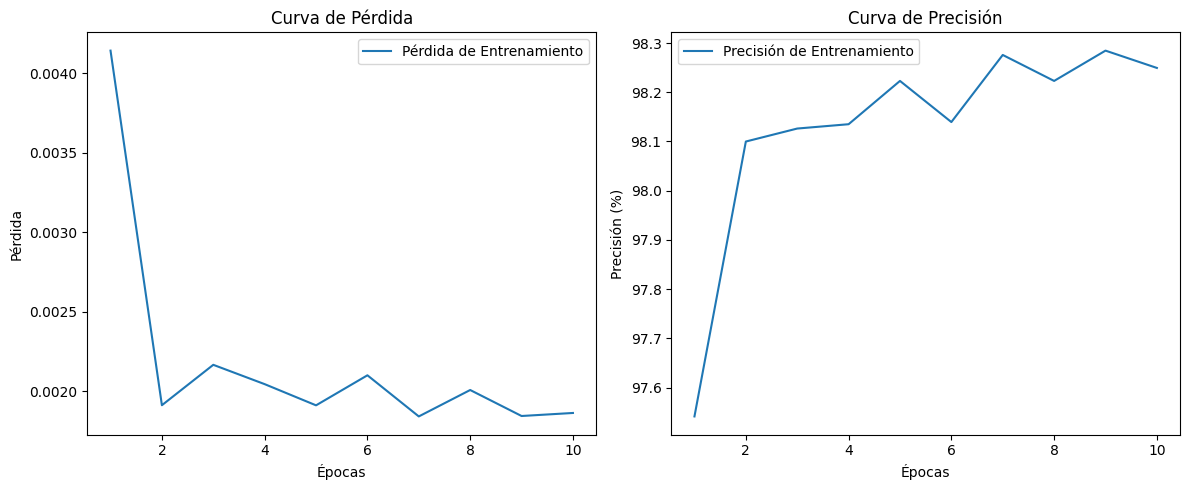

In [5]:
# from tqdm import tqdm
# from sklearn.metrics import classification_report
# import matplotlib.pyplot as plt
# from tqdm import tqdm
# import torch
# from torch.utils.data import DataLoader
# import torch.optim as optim
# import torch.nn as nn
# import pandas as pd
# from sklearn.metrics import roc_auc_score

# clinical_features = ['DBSYN', 'NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU',
#                      'NP3RIGRL', 'NP3RIGLL', 'NP3HMOVR', 'NP3HMOVL', 'NP3GAIT', 
#                      'NP3FRZGT', 'NP3PSTBL', 'NP3POSTR']
# # Crear datasets y dataloaders usando CustomDataLoader
# train_dataset = ClinicalImageDataset(
#     img_csv_path, clinical_control_csv, clinical_pd_excel, img_res=(256, 256), mode='train', img_col='mri',
#     clinical_features= clinical_features
# )
# test_dataset =  ClinicalImageDataset(
# img_csv_path, clinical_control_csv, clinical_pd_excel, img_res=(256, 256), mode='test', img_col='mri',
#     clinical_features= clinical_features
# )

# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# # Inicializar el modelo, la función de pérdida y el optimizador
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = VisionTransformer(
#     img_size=256, patch_size=16, in_chans=1, num_classes=2, embed_dim=768, depth=12, num_heads=12,
#     clinical_dim=len(train_dataset.clinical_features), use_embeddings=True
# ).to(device)
# nombre = "mri_spect_sinteticos_clinical_12_head"
# #model.load_state_dict(torch.load(f"/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/{nombre}.pth"))
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Entrenamiento del modelo
# epochs = 10
# # Listas para almacenar las métricas de entrenamiento
# train_losses = []
# train_accuracies = []
# validation_losses = []
# validation_accuracies = []
# epochs = 10
# # Entrenamiento del modelo
# for epoch in range(epochs):
#     model.train()
#     train_loss = 0.0
#     correct = 0
#     total = 0
#     with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}") as t:
#         for images, clinical_data, labels in t:
#             images, clinical_data, labels = images.to(device), clinical_data.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(images, clinical_data)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             train_loss += loss.item()
#             _, predicted = outputs.max(1)
#             total += labels.size(0)
#             correct += predicted.eq(labels).sum().item()

#             t.set_postfix(loss=train_loss / total, accuracy=100. * correct / total)

#     # Guardar métricas de la época
#     train_losses.append(train_loss / total)
#     train_accuracies.append(100. * correct / total)

# # Evaluación del modelo en el conjunto de prueba
# model.eval()
# all_labels = []
# all_predictions = []

with torch.no_grad():
    for images, clinical_data, labels in test_loader:
        images, clinical_data, labels = images.to(device), clinical_data.to(device), labels.to(device)
        outputs = model(images, clinical_data)
        _, predicted = outputs.max(1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Generar el reporte de clasificación
report = classification_report(all_labels, all_predictions, target_names=["Clase 0", "Clase 1"])
print(report)
#Calcular el AUC

auc = roc_auc_score(all_labels, all_predictions)
print(f"AUC: {auc:.4f}")

# Visualización de las métricas de entrenamiento
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

#Gráfico de pérdida
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Pérdida de Entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.title("Curva de Pérdida")
plt.legend()

# Gráfico de precisión
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Precisión de Entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Precisión (%)")
plt.title("Curva de Precisión")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# model = VisionTransformer(
#     img_size=256, patch_size=16, in_chans=1, num_classes=2, embed_dim=768, depth=12, num_heads=12,
#     clinical_dim=len(train_dataset.clinical_features), use_embeddings=True
# ).to(device)
nombre = "mri_spect_sinteticos_clinical_12_head"
model.load_state_dict(torch.load(f"/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/{nombre}.pth"))

In [4]:
#Guardar el modelo
torch.save(model.state_dict(), f"/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/{nombre}.pth")

Etiqueta real: 1, Clase predicha: 1
Variables clínicas: [0. 3. 3. 4. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]


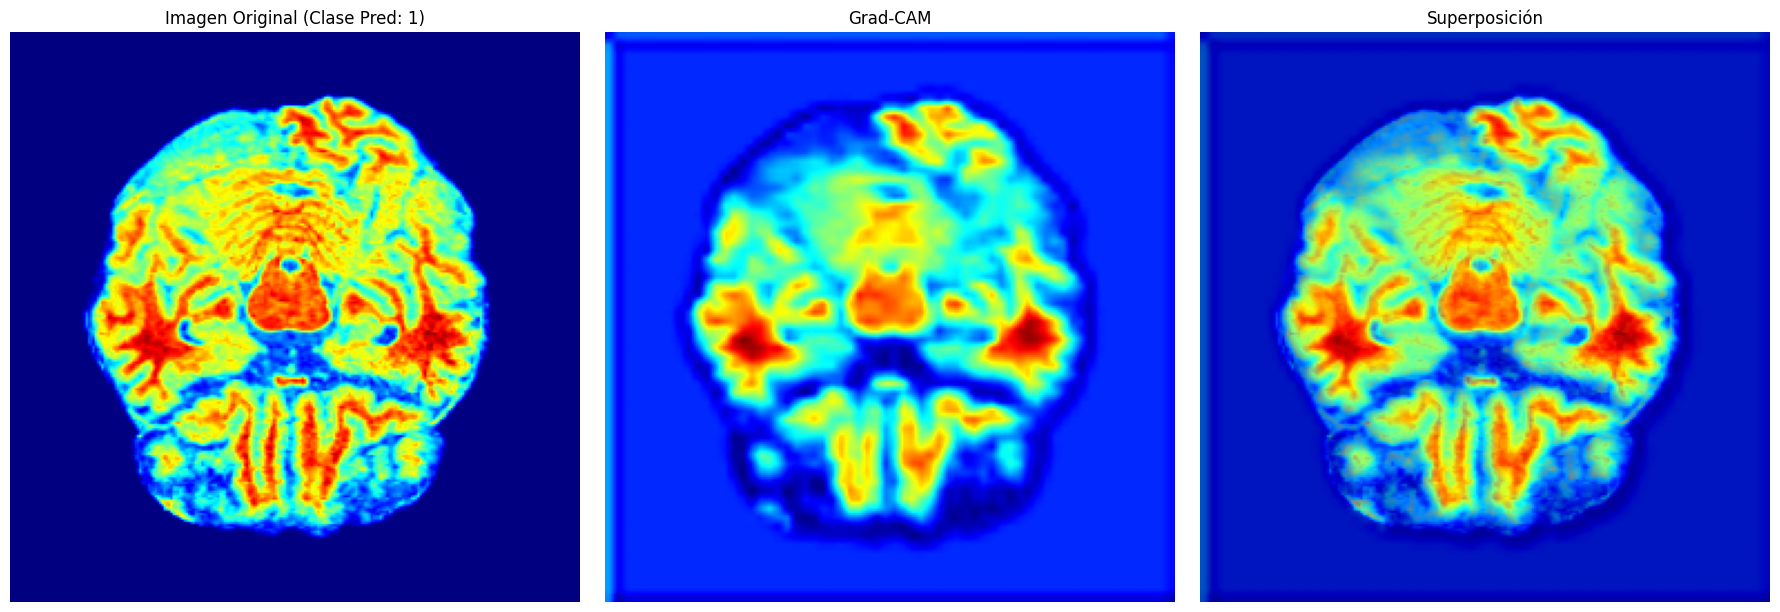

In [40]:
import numpy as np
import cv2
from matplotlib import cm
import torch
from PIL import Image
from torchvision import transforms

import matplotlib.pyplot as plt

# Función para aplicar GradCAM al modelo con variables clínicas
def vit_gradcam_clinical(model, image, clinical_data, target_class=None):
    model.eval()
    image = image.unsqueeze(0).to(device)         # (1, 1, 256, 256)
    clinical_data = clinical_data.unsqueeze(0).to(device) if clinical_data.dim() == 1 else clinical_data.to(device)
    
    features, grads = None, None

    # Hooks para capturar activaciones y gradientes de la primera etapa CNN
    def forward_hook(module, inp, out):
        nonlocal features
        features = out
    def backward_hook(module, grad_in, grad_out):
        nonlocal grads
        grads = grad_out[0]

    h_f = model.cnn_stem.stem.register_forward_hook(forward_hook)
    h_b = model.cnn_stem.stem.register_backward_hook(backward_hook)

    # Forward + backward
    logits = model(image, clinical_data)
    pred = logits.argmax(dim=-1)[0] if target_class is None else target_class
    model.zero_grad()
    logits[0, pred].backward()

    # Quitamos hooks
    h_f.remove(); h_b.remove()

    # Construcción del mapa de calor
    feat = features.detach()[0]               # (C, H, W)
    grad = grads.detach()[0]                  # (C, H, W)
    weights = grad.mean(dim=(1,2))            # (C,)
    cam = (weights[:,None,None] * feat).sum(0).cpu().numpy()  # (H, W)
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (image.size(3), image.size(2)))
    cam = (cam - cam.min())/(cam.max()-cam.min()+1e-8)

    img_np = image.squeeze().cpu().numpy()    # (1,256,256) o (256,256)
    return cam, img_np, pred.item()

def show_gradcam(cam, img, pred_class, colormap_gradcam=cv2.COLORMAP_JET, colormap_img=cv2.COLORMAP_BONE):
    # Procesar Grad-CAM
    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-8)  # Normalizar
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), colormap_gradcam)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0

    # Preparar imagen original con colormap
    if img.ndim == 2:
        base_img = img
    elif img.ndim == 3 and img.shape[0] == 1:
        base_img = img[0]
    elif img.ndim == 3:
        base_img = img.transpose(1, 2, 0)
        base_img = np.mean(base_img, axis=-1)  # Convertir a escala de grises si es RGB

    base_img = (base_img - base_img.min()) / (base_img.max() - base_img.min() + 1e-8)
    base_colormap = cv2.applyColorMap(np.uint8(255 * base_img), colormap_gradcam)
    base_colormap = cv2.cvtColor(base_colormap, cv2.COLOR_BGR2RGB) / 255.0

    # Superposición
    overlay = 0.5 * base_colormap + 0.5 * heatmap
    overlay = overlay / overlay.max()

    # Mostrar
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].imshow(base_colormap)
    axs[0].set_title(f"Imagen Original (Clase Pred: {pred_class})")
    axs[0].axis('off')

    axs[1].imshow(heatmap)
    axs[1].set_title("Grad-CAM")
    axs[1].axis('off')

    axs[2].imshow(overlay)
    axs[2].set_title("Superposición")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()

# Seleccionar una muestra aleatoria del conjunto de prueba
test_sample_idx = np.random.randint(0, len(test_dataset))
img_tensor, clinical_tensor, true_label = test_dataset[test_sample_idx]

# Aplicar GradCAM
cam, img_np, pred_class = vit_gradcam_clinical(model, img_tensor, clinical_tensor)

# Mostrar resultados
print(f"Etiqueta real: {true_label}, Clase predicha: {pred_class}")
print(f"Variables clínicas: {clinical_tensor.numpy()}")
show_gradcam(cam, img_np, pred_class)

Etiqueta real: 1, Clase predicha: 1


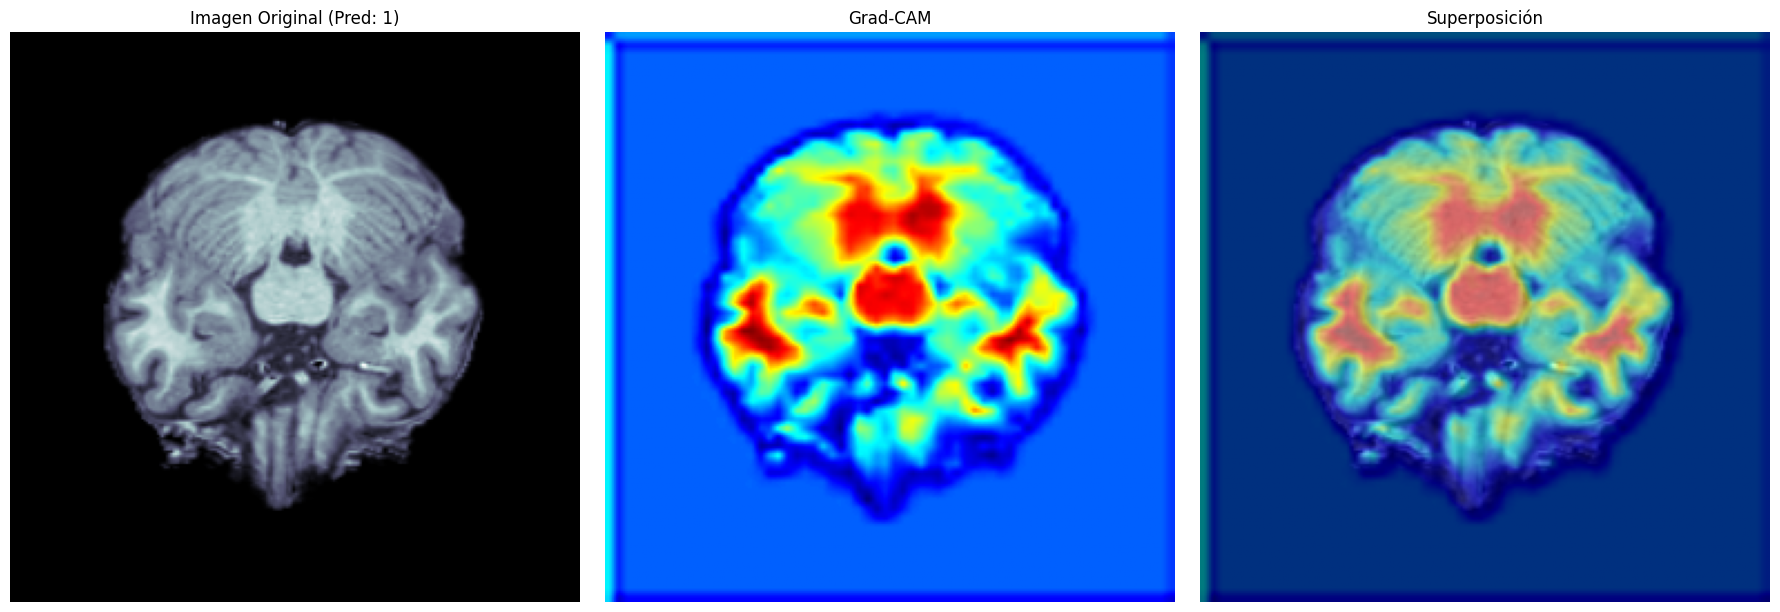

In [ ]:
import numpy as np
import cv2
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# Función para aplicar Grad-CAM
def vit_gradcam_clinical(model, image, clinical_data, target_class=None):
    model.eval()
    image = image.unsqueeze(0).to(device)  # Asegurar batch size (1, C, H, W)
    clinical_data = clinical_data.unsqueeze(0).to(device) if clinical_data.dim() == 1 else clinical_data.to(device)
    
    features, grads = None, None

    # Hooks para capturar activaciones y gradientes de la capa convolucional
    def forward_hook(module, inp, out):
        nonlocal features
        features = out

    def backward_hook(module, grad_in, grad_out):
        nonlocal grads
        grads = grad_out[0]

    # Registrar hooks en la capa adecuada
    h_f = model.cnn_stem.stem.register_forward_hook(forward_hook)
    h_b = model.cnn_stem.stem.register_backward_hook(backward_hook)

    # Forward y backward pass
    logits = model(image, clinical_data)
    pred = logits.argmax(dim=-1)[0] if target_class is None else target_class
    model.zero_grad()
    logits[0, pred].backward()

    # Eliminar hooks
    h_f.remove()
    h_b.remove()

    # Construir el mapa de calor
    feat = features.detach()[0]               # (C, H, W)
    grad = grads.detach()[0]                  # (C, H, W)
    weights = grad.mean(dim=(1, 2))           # Pesos promedio por canal (C,)
    cam = (weights[:, None, None] * feat).sum(0).cpu().numpy()  # Grad-CAM (H, W)
    cam = np.maximum(cam, 0)                  # ReLU
    cam = cv2.resize(cam, (image.size(3), image.size(2)))  # Ajustar al tamaño original
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)  # Normalizar
    return cam, image.squeeze().cpu().numpy(), pred.item()

# Función para mostrar Grad-CAM
def show_gradcam(cam, img, pred_class, colormap_gradcam=cv2.COLORMAP_JET, colormap_img=cv2.COLORMAP_BONE):
    cam = np.maximum(cam, 0) / (cam.max() + 1e-8)  # Normalizar
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), colormap_gradcam)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0

    base_img = img.squeeze() if img.ndim == 3 else img
    base_img = (base_img - base_img.min()) / (base_img.max() - base_img.min() + 1e-8)
    base_colormap = cv2.applyColorMap(np.uint8(255 * base_img), colormap_img)
    base_colormap = cv2.cvtColor(base_colormap, cv2.COLOR_BGR2RGB) / 255.0

    overlay = 0.5 * base_colormap + 0.5 * heatmap
    overlay /= overlay.max()

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].imshow(base_colormap)
    axs[0].set_title(f"Imagen Original (Pred: {pred_class})")
    axs[0].axis('off')

    axs[1].imshow(heatmap)
    axs[1].set_title("Grad-CAM")
    axs[1].axis('off')

    axs[2].imshow(overlay)
    axs[2].set_title("Superposición")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()

# Ejemplo de prueba
test_sample_idx = np.random.randint(0, len(test_dataset))
img_tensor, clinical_tensor, true_label = test_dataset[test_sample_idx]

cam, img_np, pred_class = vit_gradcam_clinical(model, img_tensor, clinical_tensor)

# Mostrar resultados
print(f"Etiqueta real: {true_label}, Clase predicha: {pred_class}")
show_gradcam(cam, img_np, pred_class)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000000000000002].


Etiqueta real: 1, Clase predicha: 1


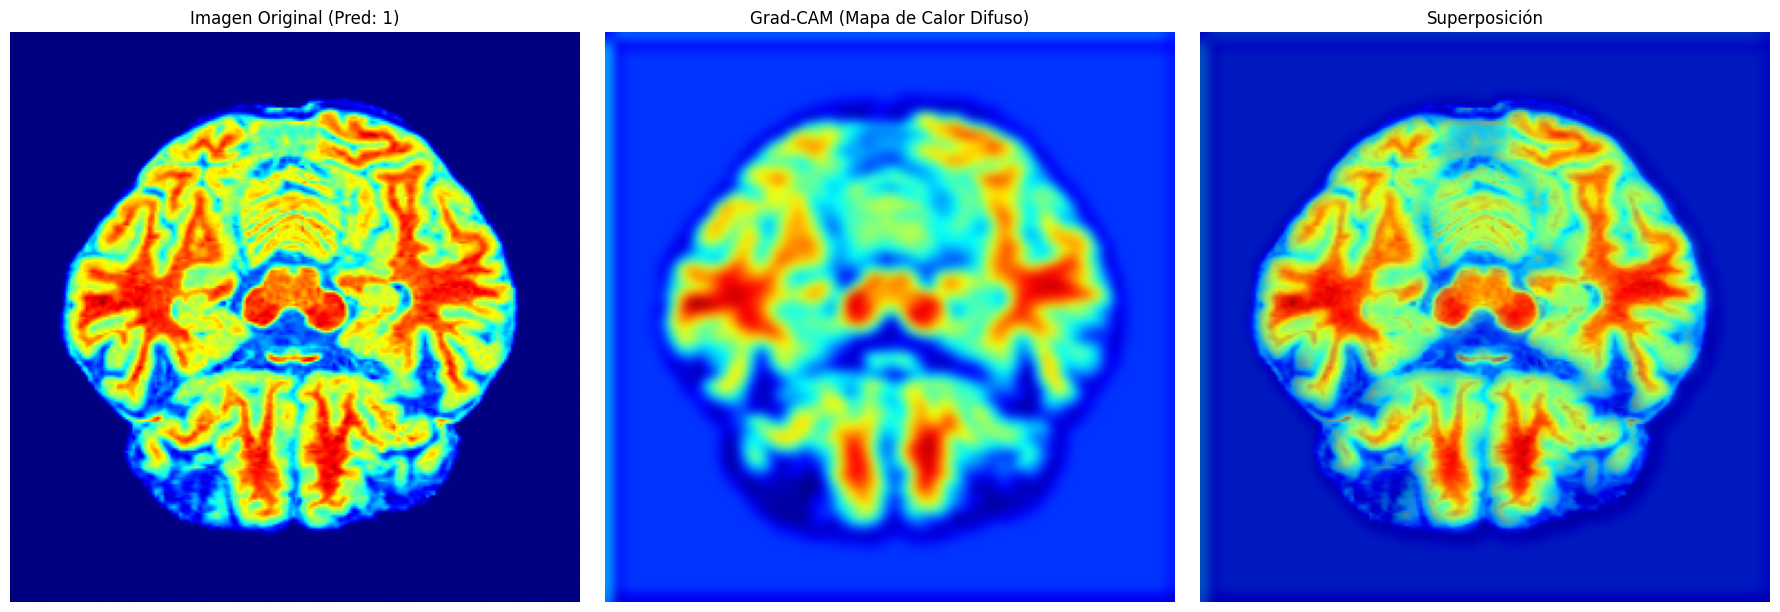

In [ ]:
def vit_gradcam_clinical(model, image, clinical_data, target_class=None):
    model.eval()
    image = image.unsqueeze(0).to(device)
    clinical_data = clinical_data.unsqueeze(0).to(device) if clinical_data.dim() == 1 else clinical_data.to(device)

    features, grads = None, None

    # Hooks para capturar activaciones y gradientes
    def forward_hook(module, inp, out):
        nonlocal features
        features = out

    def backward_hook(module, grad_in, grad_out):
        nonlocal grads
        grads = grad_out[0]

    # Registrar hooks en una capa convolucional representativa
    h_f = model.cnn_stem.stem.register_forward_hook(forward_hook)
    h_b = model.cnn_stem.stem.register_backward_hook(backward_hook)

    # Forward y backward pass
    logits = model(image, clinical_data)
    pred = logits.argmax(dim=-1)[0] if target_class is None else target_class
    model.zero_grad()
    logits[0, pred].backward()

    # Remover hooks
    h_f.remove()
    h_b.remove()

    # Construcción del Grad-CAM
    feat = features.detach()[0]  # Mapas de características (C, H, W)
    grad = grads.detach()[0]     # Gradientes (C, H, W)
    weights = grad.mean(dim=(1, 2))  # Promedio global de gradientes (C,)
    cam = (weights[:, None, None] * feat).sum(0).cpu().numpy()  # Grad-CAM (H, W)
    cam = np.maximum(cam, 0)  # Aplicar ReLU para eliminar valores negativos

    # Redimensionar y normalizar el Grad-CAM
    cam = cv2.resize(cam, (image.size(3), image.size(2)))  # Ajustar tamaño
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)  # Normalizar
    return cam, image.squeeze().cpu().numpy(), pred.item()

# Mostrar el Grad-CAM superpuesto
def show_gradcam(cam, img, pred_class, colormap_gradcam=cv2.COLORMAP_JET, colormap_img=cv2.COLORMAP_BONE):
    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-8)  # Normalización
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), colormap_gradcam)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0

    # Imagen original en escala de grises
    base_img = img.squeeze() if img.ndim == 3 else img
    base_img = (base_img - base_img.min()) / (base_img.max() - base_img.min() + 1e-8)
    base_colormap = cv2.applyColorMap(np.uint8(255 * base_img), colormap_gradcam)
    base_colormap = cv2.cvtColor(base_colormap, cv2.COLOR_BGR2RGB) / 255.0

    # Suavizado del Grad-CAM (opcional para zonas difusas)
    heatmap = cv2.GaussianBlur(heatmap, (11, 11), 0)

    # Superposición
    overlay = 0.5 * base_colormap + 0.5 * heatmap
    overlay = overlay / overlay.max()

    # Visualización
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].imshow(base_colormap)
    axs[0].set_title(f"Imagen Original (Pred: {pred_class})")
    axs[0].axis('off')

    axs[1].imshow(heatmap)
    axs[1].set_title("Grad-CAM (Mapa de Calor Difuso)")
    axs[1].axis('off')

    axs[2].imshow(overlay)
    axs[2].set_title("Superposición")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()

test_sample_idx = np.random.randint(0, len(test_dataset))
img_tensor, clinical_tensor, true_label = test_dataset[test_sample_idx]

cam, img_np, pred_class = vit_gradcam_clinical(model, img_tensor, clinical_tensor)

# Mostrar resultados
print(f"Etiqueta real: {true_label}, Clase predicha: {pred_class}")
show_gradcam(cam, img_np, pred_class)

# MRI + SPECT* + Clinical

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
import pandas as pd
import os

class ClinicalImageDataset(Dataset):
    def __init__(self, img_csv_path, clinical_control_csv, clinical_pd_excel, img_res=(256, 256), 
                 mode='train', img_col='mri', clinical_features=None, spect_synth_path=None):
        self.img_df = pd.read_csv(img_csv_path)
        self.control_df = pd.read_csv(clinical_control_csv)
        self.pd_df = pd.read_excel(clinical_pd_excel, sheet_name='PD')
        self.img_res = img_res
        self.mode = mode
        self.img_col = img_col
        
        # Load synthetic SPECT data if provided
        self.spect_synth_df = None
        if spect_synth_path and os.path.exists(spect_synth_path):
            self.spect_synth_df = pd.read_csv(spect_synth_path)
            print(f"Loaded synthetic SPECT data: {len(self.spect_synth_df)} records")
        
        # Define clinical features to use if not provided
        self.clinical_features = clinical_features if clinical_features is not None else [
            'DBSYN', 'NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 
            'NP3RIGRL', 'NP3RIGLL', 'NP3HMOVR', 'NP3HMOVL', 'NP3GAIT', 'NP3FRZGT', 
            'NP3PSTBL', 'NP3POSTR'
        ]
        
        # Filter images by mode
        self.img_train_df = self.img_df[self.img_df[f'tipo_{self.img_col}'] == 'train']
        self.img_test_df = self.img_df[self.img_df[f'tipo_{self.img_col}'] == 'test']
        
        # Create samples list with available clinical data
        self.samples = []
        
        # Select appropriate dataset based on mode
        img_dataset = self.img_train_df if mode == 'train' else self.img_test_df
        
        # For each image, try to find its clinical data
        for idx, row in img_dataset.iterrows():
            patient_id = int(row[f'paciente_{self.img_col}'])
            label = int(row[f'clase_{self.img_col}'])
            
            # Find clinical data based on label (0=control, 1=PD)
            clinical_data = None
            if label == 0:
                # Search in control dataframe
                control_patient = self.control_df[self.control_df['Pat_id'] == int(patient_id)]
                if not control_patient.empty:
                    clinical_data = control_patient[self.clinical_features].iloc[0]
            else:
                # Search in PD dataframe
                pd_patient = self.pd_df[self.pd_df['Pat_id'] == patient_id]
                if not pd_patient.empty:
                    clinical_data = pd_patient[self.clinical_features].iloc[0]
            
            # Find synthetic SPECT if available
            spect_data = None
            if self.spect_synth_df is not None:
                spect_patient = self.spect_synth_df[self.spect_synth_df['paciente_spect'] == int(patient_id)]
                if not spect_patient.empty:
                    spect_path = spect_patient['path_spect'].iloc[0]
                    if os.path.exists(spect_path):
                        spect_data = spect_path
            
            # If clinical data is available, add to samples
            if clinical_data is not None:
                self.samples.append((row, clinical_data, label, spect_data))
        
        # Print dataset summary
        print(f"Mode: {mode}, Total samples with clinical data: {len(self.samples)}")
        if self.spect_synth_df is not None:
            spect_count = sum(1 for _, _, _, spect in self.samples if spect is not None)
            print(f"Samples with synthetic SPECT: {spect_count}")
        
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize(self.img_res),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_row, clinical_data, label, spect_path = self.samples[idx]
        
        # Process MRI image
        img_path = img_row[f'path_{self.img_col}']
        try:
            img = Image.open(img_path)
            img_tensor = self.transform(img)
        except Exception as e:
            print(f"Error loading MRI image {img_path}: {e}")
            # Create an empty tensor as fallback
            img_tensor = torch.zeros((1, *self.img_res))
        
        # Process SPECT image if available
        spect_tensor = None
        if spect_path:
            try:
                spect_img = Image.open(spect_path)
                spect_tensor = self.transform(spect_img)
            except Exception as e:
                print(f"Error loading SPECT image {spect_path}: {e}")
                spect_tensor = torch.zeros((1, *self.img_res))
        else:
            spect_tensor = torch.zeros((1, *self.img_res))
        
        # Process clinical features
        clinical_values = []
        for feature in self.clinical_features:
            if feature in clinical_data:
                # Try to convert to float, use 0.0 if conversion fails
                try:
                    value = float(clinical_data[feature])
                    clinical_values.append(value)
                except (ValueError, TypeError):
                    clinical_values.append(0.0)
            else:
                clinical_values.append(0.0)  # Default value if feature not found
        
        clinical_tensor = torch.tensor(clinical_values, dtype=torch.float)
        
        return img_tensor, spect_tensor, clinical_tensor, label

# Example usage
img_csv_path = '/home/Data/franklin_pupils/yeferson/Tesis/Datos_mri_spect_clinical.csv'
clinical_control_csv = '/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/embcExtension_control.csv'
clinical_pd_excel = '/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/embcExtension.xlsx'
spect_sinteticos = '/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/spect_sinteticos_filtrados.csv'

# # Create dataset with synthetic SPECT
# dataset = ClinicalImageDataset(
#     img_csv_path=img_csv_path,
#     clinical_control_csv=clinical_control_csv,
#     clinical_pd_excel=clinical_pd_excel,
#     spect_synth_path=spect_sinteticos,
#     mode='train'
# )
# import matplotlib.pyplot as plt
# # Test if loading works for a few samples
# if len(dataset) > 0:
#     for i in range(min(3, len(dataset))):
#         mri, spect, clinical, label = dataset[i+100]
#         print(f"Sample {i}:")
#         print(f"  MRI shape: {mri.shape}")
#         print(f"  SPECT shape: {spect.shape}")
#         print(f"  Clinical features: {clinical.shape}")
#         print(f"  Label: {label}")
#         print(f"  Clinical values: {clinical}")
#         plt.figure(figsize=(12, 4))
#         plt.subplot(1, 3, 1)
#         plt.imshow(mri.squeeze(), cmap='gray')
#         plt.title('MRI')
#         plt.axis('off')
#         plt.subplot(1, 3, 2)
#         plt.imshow(spect.squeeze(), cmap='gray')
#         plt.title('SPECT')
#         plt.axis('off')
#         plt.subplot(1, 3, 3)
#         plt.bar(range(len(clinical)), clinical.numpy())
#         plt.title('Clinical Features')
#         plt.xticks(range(len(clinical)), dataset.clinical_features, rotation=45)
#         plt.tight_layout()
#         plt.show()
# else:
#     print("No samples found! Check your data paths.")

In [2]:
import torch
import torch.nn as nn
import math

class CNNStem(nn.Module):
    def __init__(self, in_chans=1, out_chans=128):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(in_chans, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, out_chans, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_chans),
            nn.ReLU()
        )

    def forward(self, x):
        return self.stem(x)

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=64, patch_size=4, in_chans=128, embed_dim=768):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch, W/patch)
        x = x.flatten(2).transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, dropout=0.0):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=True)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropout)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
        q, k, v = qkv.permute(2, 0, 3, 1, 4)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return self.proj_drop(x)

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, dropout=0.0):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        x = self.drop(self.act(self.fc1(x)))
        x = self.drop(self.fc2(x))
        return x

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, int(dim * mlp_ratio), dropout=dropout)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class ClinicalEncoder(nn.Module):
    def __init__(self, clinical_dim, num_categories=5, embed_dim_per_var=16, output_dim=768):
        super().__init__()
        self.clinical_dim = clinical_dim
        self.num_categories = num_categories
        
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_categories, embed_dim_per_var) 
            for _ in range(clinical_dim)
        ])
        
        total_embed_dim = clinical_dim * embed_dim_per_var
        self.encoder = nn.Sequential(
            nn.Linear(total_embed_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, output_dim)
        )
    
    def forward(self, x):
        embedded_features = []
        for i in range(self.clinical_dim):
            var_values = x[:, i].long()
            embedded = self.embeddings[i](var_values)
            embedded_features.append(embedded)
        
        combined = torch.cat(embedded_features, dim=1)
        return self.encoder(combined)

class MultiModalVisionTransformer(nn.Module):
    def __init__(self, img_size=256, patch_size=16, in_chans=1, num_classes=2,
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.0, dropout=0.1,
                 clinical_dim=14, use_embeddings=True):
        super().__init__()
        # MRI processing path
        self.mri_stem = CNNStem(in_chans=in_chans, out_chans=128)
        
        # SPECT processing path
        self.spect_stem = CNNStem(in_chans=in_chans, out_chans=128)
        
        reduced_img_size = img_size // 4
        
        # Shared patch embedding
        self.patch_embed = PatchEmbedding(
            img_size=reduced_img_size, patch_size=patch_size,
            in_chans=128, embed_dim=embed_dim
        )
        num_patches = self.patch_embed.num_patches

        # Tokens and positional embeddings
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + num_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=dropout)

        # Transformer blocks
        self.blocks = nn.Sequential(*[
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout) for _ in range(depth)
        ])
        
        # Separate blocks for SPECT
        self.spect_blocks = nn.Sequential(*[
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout) for _ in range(depth//2)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        
        # Clinical encoder
        if use_embeddings:
            self.clinical_encoder = ClinicalEncoder(
                clinical_dim=clinical_dim, 
                num_categories=5, 
                embed_dim_per_var=16, 
                output_dim=embed_dim
            )
        else:
            self.clinical_encoder = SimpleClinicalEncoder(
                clinical_dim=clinical_dim, 
                output_dim=embed_dim
            )
        
        # Cross-modal fusion with attention
        self.fusion_attention = nn.MultiheadAttention(embed_dim, num_heads=8, dropout=0.1)
        self.fusion_norm = nn.LayerNorm(embed_dim)
        
        # Final multimodal fusion
        self.multimodal_fusion = nn.Sequential(
            nn.Linear(embed_dim * 3, embed_dim),
            nn.LayerNorm(embed_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 2),
            nn.LayerNorm(embed_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(embed_dim // 2, num_classes)
        )

        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, mri, spect, clinical_data):
        B = mri.shape[0]
        
        # Process MRI
        mri_features = self.mri_stem(mri)
        mri_features = self.patch_embed(mri_features)
        mri_cls_tokens = self.cls_token.expand(B, -1, -1)
        mri_features = torch.cat((mri_cls_tokens, mri_features), dim=1)
        mri_features = self.pos_drop(mri_features + self.pos_embed)
        mri_features = self.blocks(mri_features)
        mri_features = self.norm(mri_features[:, 0])  # [B, embed_dim]
        
        # Process SPECT
        spect_features = self.spect_stem(spect)
        spect_features = self.patch_embed(spect_features)
        spect_cls_tokens = self.cls_token.expand(B, -1, -1)
        spect_features = torch.cat((spect_cls_tokens, spect_features), dim=1)
        spect_features = self.pos_drop(spect_features + self.pos_embed)
        spect_features = self.spect_blocks(spect_features)
        spect_features = self.norm(spect_features[:, 0])  # [B, embed_dim]
        
        # Process clinical data
        clinical_features = self.clinical_encoder(clinical_data)  # [B, embed_dim]
        
        # Concatenate all modalities for fusion
        combined_features = torch.cat([
            mri_features, spect_features, clinical_features
        ], dim=1)  # [B, embed_dim*3]
        
        # Final fusion
        fused_features = self.multimodal_fusion(combined_features)  # [B, embed_dim]
        
        # Classification
        return self.classifier(fused_features)


Loaded synthetic SPECT data: 26390 records
Mode: train, Total samples with clinical data: 22736
Samples with synthetic SPECT: 22736
Loaded synthetic SPECT data: 26390 records
Mode: test, Total samples with clinical data: 5684
Samples with synthetic SPECT: 5684


Epoch 10/10: 100%|█████████████████████████████████████████████████████| 1421/1421 [04:16<00:00,  5.54it/s, accuracy=99.8, loss=0.000465]


              precision    recall  f1-score   support

     Control       0.93      0.93      0.93      2940
   Parkinson       0.93      0.93      0.93      2744

    accuracy                           0.93      5684
   macro avg       0.93      0.93      0.93      5684
weighted avg       0.93      0.93      0.93      5684

AUC: 0.9619


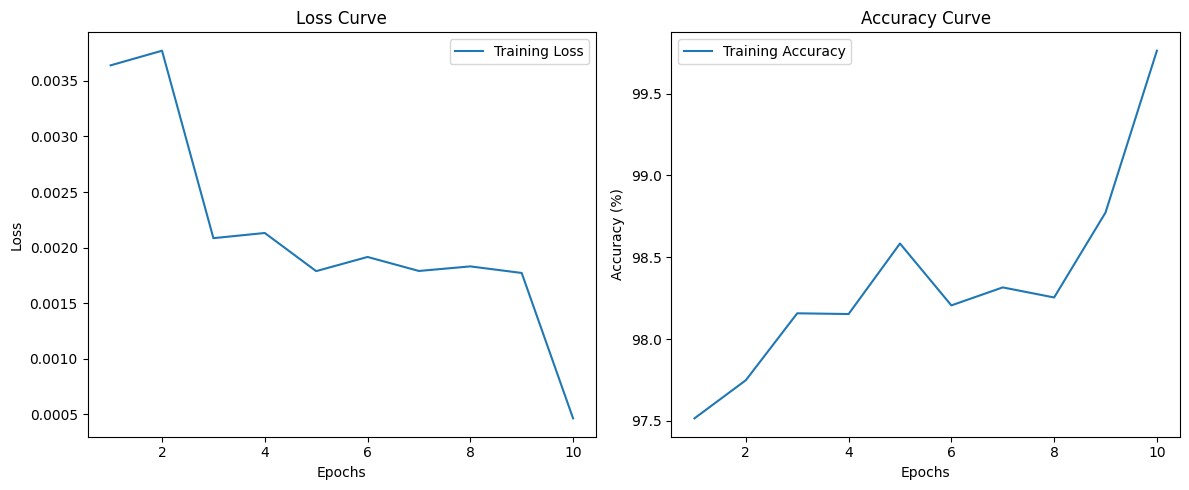

In [4]:
from tqdm import tqdm
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import pandas as pd
from sklearn.metrics import roc_auc_score

clinical_features = ['DBSYN', 'NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU',
                     'NP3RIGRL', 'NP3RIGLL', 'NP3HMOVR', 'NP3HMOVL', 'NP3GAIT', 
                     'NP3FRZGT', 'NP3PSTBL', 'NP3POSTR']

# Create datasets and dataloaders for MRI+SPECT+clinical data
train_dataset = ClinicalImageDataset(
    img_csv_path, clinical_control_csv, clinical_pd_excel, 
    img_res=(256, 256), mode='train', img_col='mri',
    clinical_features=clinical_features, spect_synth_path=spect_sinteticos
)
test_dataset = ClinicalImageDataset(
    img_csv_path, clinical_control_csv, clinical_pd_excel, 
    img_res=(256, 256), mode='test', img_col='mri',
    clinical_features=clinical_features, spect_synth_path=spect_sinteticos
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize model, loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiModalVisionTransformer(
    img_size=256, patch_size=16, in_chans=1, num_classes=2, embed_dim=768, depth=12, num_heads=12,
    clinical_dim=len(train_dataset.clinical_features), use_embeddings=True
).to(device)
nombre = "mri_spect_sinteticos_clinical_12_head"
# Uncomment to load a pre-trained model
#model.load_state_dict(torch.load(f"/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/{nombre}.pth"))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
epochs = 10
train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}") as t:
        for mri_images, spect_images, clinical_data, labels in t:
            mri_images, spect_images, clinical_data, labels = mri_images.to(device), spect_images.to(device), clinical_data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(mri_images, spect_images, clinical_data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            t.set_postfix(loss=train_loss / total, accuracy=100. * correct / total)

    # Save metrics for the epoch
    train_losses.append(train_loss / total)
    train_accuracies.append(100. * correct / total)

# Evaluate model on test set
model.eval()
all_labels = []
all_predictions = []
all_probs = []

with torch.no_grad():
    for mri_images, spect_images, clinical_data, labels in test_loader:
        mri_images, spect_images, clinical_data, labels = mri_images.to(device), spect_images.to(device), clinical_data.to(device), labels.to(device)
        outputs = model(mri_images, spect_images, clinical_data)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_probs.extend(probabilities[:, 1].cpu().numpy())  # For AUC, use probability of class 1

# Generate classification report
report = classification_report(all_labels, all_predictions, target_names=["Control", "Parkinson"])
print(report)

# Calculate AUC
auc = roc_auc_score(all_labels, all_probs)
print(f"AUC: {auc:.4f}")

# Visualization of training metrics
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

# Save the model
torch.save(model.state_dict(), f"/home/Data/franklin_pupils/yeferson/Modelo_clasificacion/{nombre}.pth")